<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>

# Preprocesamiento de Datos para un Modelo de Clasificación

Nuestro equipo de riesgo ha identificado la necesidad de construir un modelo de clasificación para detectar transacciones potencialmente fraudulentas o anómalas. El éxito de este modelo permitirá identificar patrones en los datos y reducir pérdidas económicas para nuestros clientes y la empresa. Tu trabajo para hoy será preparar los datos proporcionados para desarrollar un modelo de clasificación que prediga la probabilidad de que una transacción sea “Normal” o “Anómala”, basándose en las características de las transacciones. Dentro de las tareas que tienes que realizar hoy deben estar incluidas las siguientes: 


1. **Análisis exploratorio de datos (EDA):**

   - Visualizar la distribución de las principales variables.

   - Explorar relaciones entre las características y la variable objetivo (`TransactionStatus`).


2. **Limpieza de datos:**

   - Identificar y tratar valores nulos.

   - Eliminar duplicados si existen.

   - Asegurar que las variables tienen el tipo de dato correcto.

   - etc. 

3. **Transformación de variables:**

   - Normalizar o escalar variables numéricas según sea necesario.

   - Codificar variables categóricas con técnicas como One-Hot Encoding, Target Encoding u Ordinal Encoding, según corresponda.

   - Crear variables derivadas útiles, como:

     - Frecuencia de transacciones de cada cliente.

     - Diferencia de tiempo entre transacciones consecutivas.

     - Ratio entre el saldo posterior y el monto de la transacción.

## Datos Proporcionados

El archivo de datos que analizarán contiene transacciones reales registradas por una compañia. A continuación, se describen las principales columnas que deberán preprocesar:

| Columna               | Descripción                                                                                     |
|-----------------------|-------------------------------------------------------------------------------------------------|
| `transaction_id`      | Identificador único de la transacción.                                                         |
| `customer_id`         | Identificador único del cliente que realizó la transacción.                                    |
| `merchant_id`         | Identificador único del comercio donde se realizó la transacción.                              |
| `amount`              | Monto de la transacción (en la moneda correspondiente).                                        |
| `transaction_time`    | Fecha y hora exacta en la que ocurrió la transacción.                                          |
| `is_fraudulent`       | Indicador de si la transacción fue fraudulenta (1: Sí, 0: No).                                 |
| `card_type`           | Tipo de tarjeta utilizada para la transacción (Visa, MasterCard, American Express, Discover).  |
| `location`            | Ubicación (ciudad o región) donde se realizó la transacción.                                   |
| `purchase_category`   | Categoría de la compra (por ejemplo, Gas Station, Online Shopping, Retail, etc.).              |
| `customer_age`        | Edad del cliente en el momento de la transacción.                                              |
| `transaction_description` | Descripción breve de la transacción, usualmente incluye el comercio asociado.              |


In [131]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Importamos las clases creadas para hace el EDA
# -----------------------------------------------------------------------
from src import soporte_logistica_preprocesamiento as sl
from src import soporte_encoding_logistica as se

# Ignorar warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

from src.SupportOutliers import (
    plot_outliers_univariados,
    identificar_outliers_iqr,
    identificar_outliers_z,
    visualizar_outliers_bivariados,
    explorar_outliers_if,
    explorar_outliers_lof
)
import pickle
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, RobustScaler
from itertools import product , combinations
from sklearn.experimental import enable_iterative_imputer  # Necesario para habilitar IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

In [63]:
df = pd.read_csv("datos/financial_data.csv")

In [64]:
df.sample()

,transaction_id,customer_id,merchant_id,amount,transaction_time,is_fraudulent,card_type,location,purchase_category,customer_age,transaction_description
6418,6419,1100,2027,9547.97,2023-01-01 01:46:58,1,MasterCard,City-39,Travel,24,Purchase at Merchant-2027


In [65]:
# leemos el dataframe
sl.exploracion_datos(df)

El número de filas es 10000 y el número de columnas es 11

----------

En este conjunto de datos tenemos 0 valores duplicados

----------

Los columnas con valores nulos y sus porcentajes son: 


Series([], dtype: float64)


----------

Las principales estadísticas de las variables númericas son:


,count,mean,std,min,25%,50%,75%,max
transaction_id,10000.0,5000.500000,2886.895680,1.00,2500.750,5000.500,7500.2500,10000.00
customer_id,10000.0,1051.272300,28.864062,1001.00,1026.000,1052.000,1076.0000,1100.00
merchant_id,10000.0,2050.486600,28.877801,2001.00,2025.000,2050.000,2076.0000,2100.00
amount,10000.0,4958.381617,2899.699675,10.61,2438.175,4943.945,7499.3125,9999.75
is_fraudulent,10000.0,0.506800,0.499979,0.00,0.000,1.000,1.0000,1.00
customer_age,10000.0,44.047500,15.321707,18.00,31.000,44.000,57.0000,70.00



----------

Las principales estadísticas de las variables categóricas son:


,count,unique,top,freq
transaction_time,10000,10000,2023-01-01 02:46:23,1
card_type,10000,4,Discover,2633
location,10000,50,City-7,223
purchase_category,10000,6,Travel,1694
transaction_description,10000,100,Purchase at Merchant-2016,120



----------

Las características principales del dataframe son:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   transaction_id           10000 non-null  int64  
 1   customer_id              10000 non-null  int64  
 2   merchant_id              10000 non-null  int64  
 3   amount                   10000 non-null  float64
 4   transaction_time         10000 non-null  object 
 5   is_fraudulent            10000 non-null  int64  
 6   card_type                10000 non-null  object 
 7   location                 10000 non-null  object 
 8   purchase_category        10000 non-null  object 
 9   customer_age             10000 non-null  int64  
 10  transaction_description  10000 non-null  object 
dtypes: float64(1), int64(5), object(5)
memory usage: 859.5+ KB


None

In [66]:
df.head()

,transaction_id,customer_id,merchant_id,amount,transaction_time,is_fraudulent,card_type,location,purchase_category,customer_age,transaction_description
0,1,1082,2027,5758.59,2023-01-01 00:00:00,0,MasterCard,City-30,Gas Station,43,Purchase at Merchant-2027
1,2,1015,2053,1901.56,2023-01-01 00:00:01,1,Visa,City-47,Online Shopping,61,Purchase at Merchant-2053
2,3,1004,2035,1248.86,2023-01-01 00:00:02,1,MasterCard,City-6,Gas Station,57,Purchase at Merchant-2035
3,4,1095,2037,7619.05,2023-01-01 00:00:03,1,Discover,City-6,Travel,59,Purchase at Merchant-2037
4,5,1036,2083,1890.10,2023-01-01 00:00:04,1,MasterCard,City-34,Retail,36,Purchase at Merchant-2083


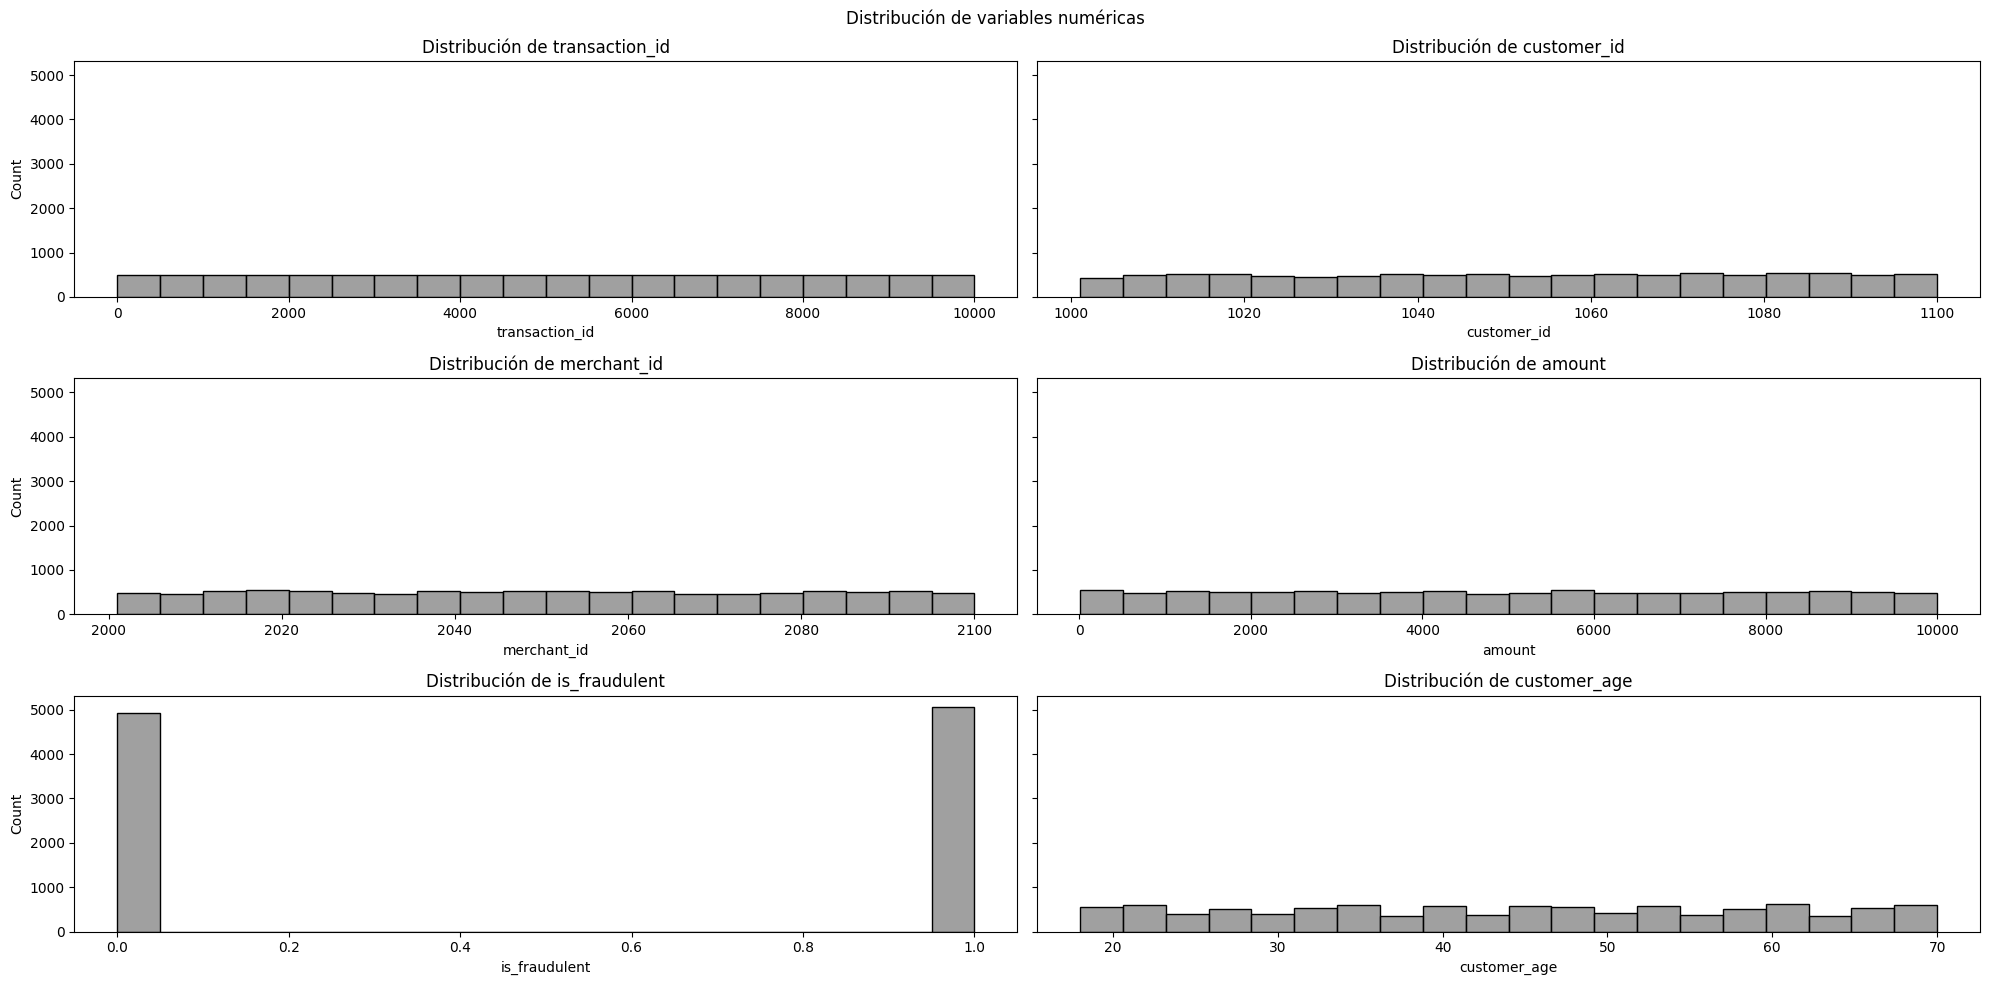

In [67]:
# Crear una instancia de la clase y llamar a los métodos
visualizador =sl.Visualizador(df)

# exploramos la distribución de las variables numéricas
visualizador.plot_numericas()

### Sobre la gráfica
- Quitando la variable respuesta
- La distribución parece igual para todas

# Plot categoricas
- Quitamos transaction time porque tiene demasiados

In [68]:
df.columns

Index(['transaction_id', 'customer_id', 'merchant_id', 'amount',
       'transaction_time', 'is_fraudulent', 'card_type', 'location',
       'purchase_category', 'customer_age', 'transaction_description'],
      dtype='object')

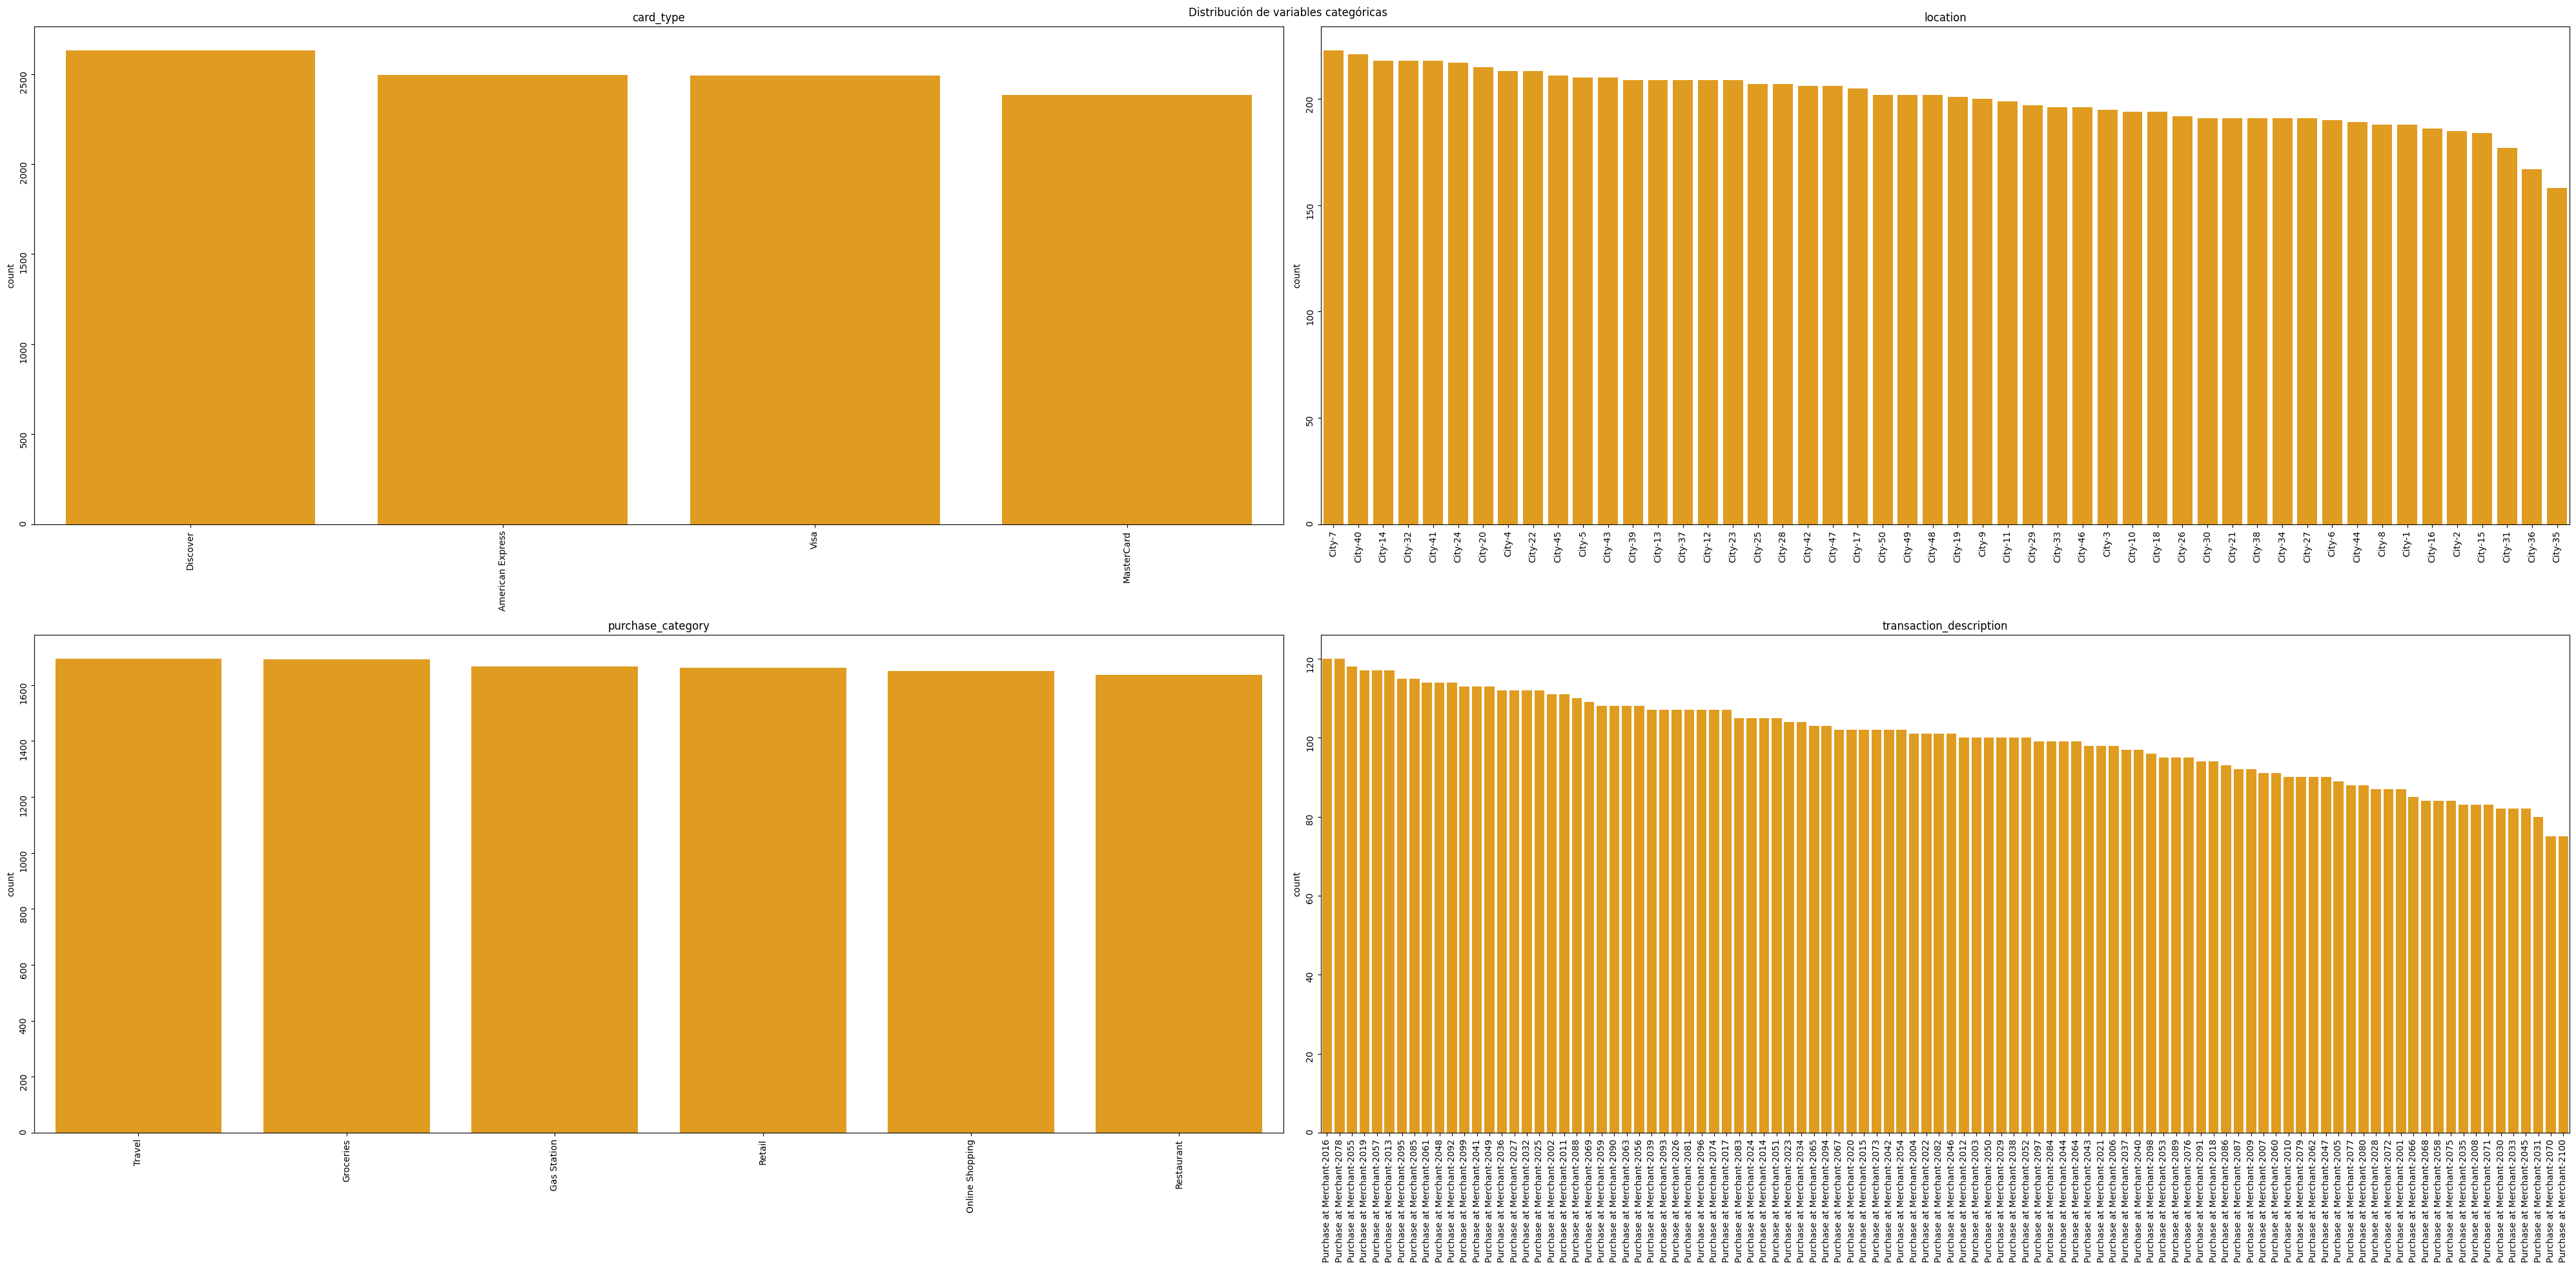

In [69]:
# Crear una instancia de la clase y llamar a los métodos
visualizador2 =sl.Visualizador(df[['transaction_id', 'customer_id', 'merchant_id', 'amount',
                                    'is_fraudulent', 'card_type', 'location',
                                    'purchase_category', 'customer_age', 'transaction_description']])

# evaluamos la distribución de las variables categóricas
visualizador2.plot_categoricas(color = "orange",tamano_grafica=(40,20))

PURCHASE STATUS y PURCHASE_CATEGORY

# Ver Outliers

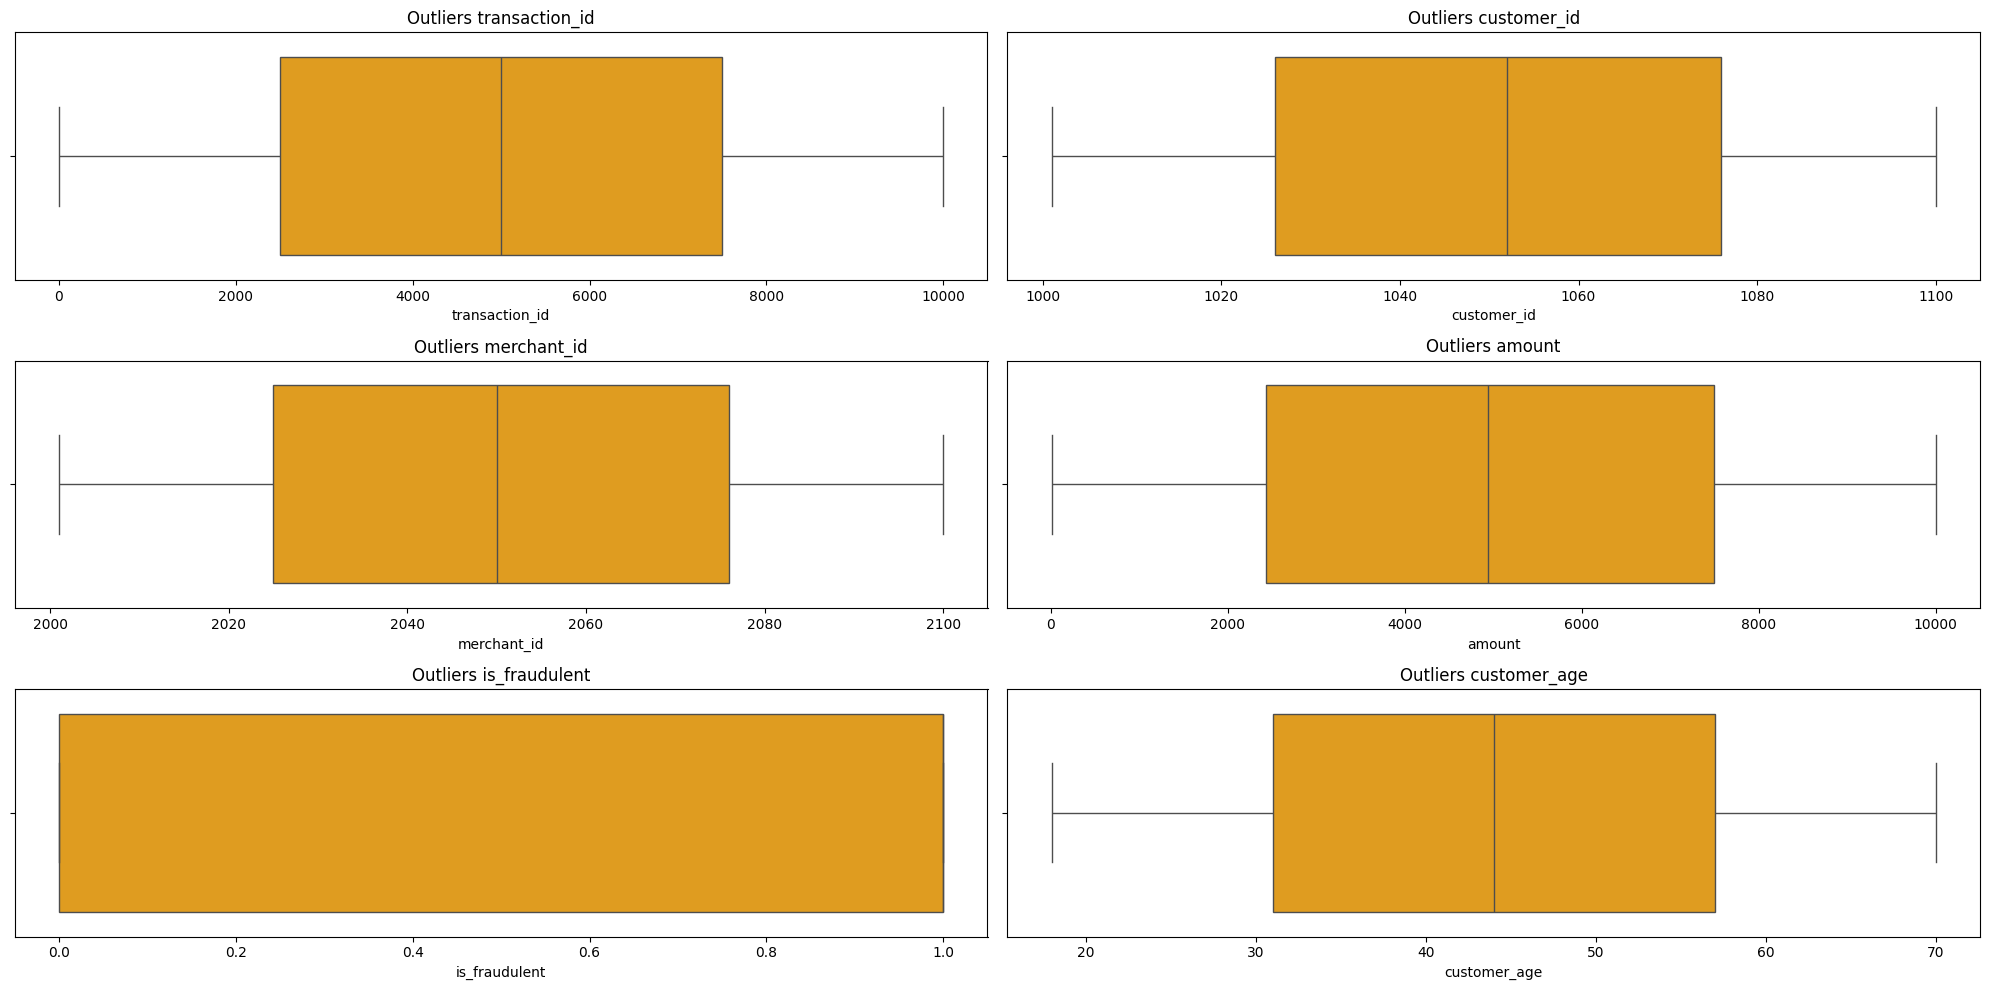

In [70]:
# detectamos los outliers
visualizador.deteccion_outliers(color = "orange")

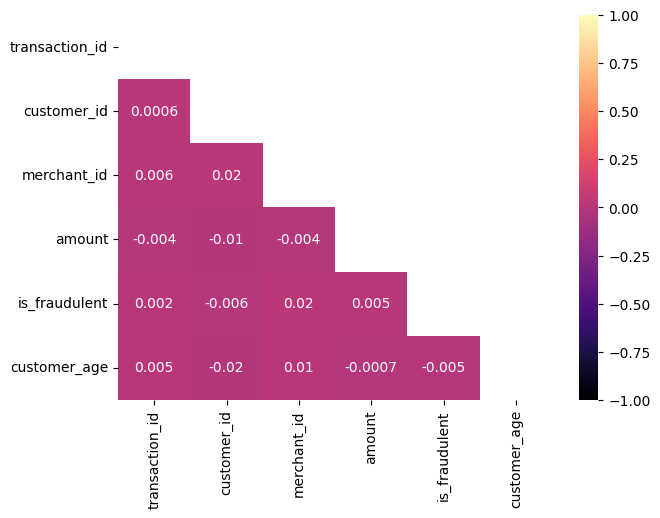

In [71]:
# evaluamos las correlaciones entre las variables numéricas
visualizador.correlacion()

### Conclusiones
- Las relaciones son extremadamentes débiles, cercanas a 0
- Esto sugieres que no hay relaciones fuertes entre ninguna de las variables
- Podemos considerarlas prácticamente independientes unas de otras.

2. **Limpieza de datos:**

   - Identificar y tratar valores nulos.

   - Eliminar duplicados si existen.

   - Asegurar que las variables tienen el tipo de dato correcto.

   - etc. 

# Datos correctos

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   transaction_id           10000 non-null  int64  
 1   customer_id              10000 non-null  int64  
 2   merchant_id              10000 non-null  int64  
 3   amount                   10000 non-null  float64
 4   transaction_time         10000 non-null  object 
 5   is_fraudulent            10000 non-null  int64  
 6   card_type                10000 non-null  object 
 7   location                 10000 non-null  object 
 8   purchase_category        10000 non-null  object 
 9   customer_age             10000 non-null  int64  
 10  transaction_description  10000 non-null  object 
dtypes: float64(1), int64(5), object(5)
memory usage: 859.5+ KB


Parecen correctos

# Eliminar transaction_time

In [73]:
df.drop(columns="transaction_time",inplace=True)

# Nulos

In [74]:
df.isnull().sum()

transaction_id             0
customer_id                0
merchant_id                0
amount                     0
is_fraudulent              0
card_type                  0
location                   0
purchase_category          0
customer_age               0
transaction_description    0
dtype: int64

No hay nulos

# Duplicados

In [75]:
df.duplicated().sum()

np.int64(0)

No hay duplicados

# Outliers

### Multivariados

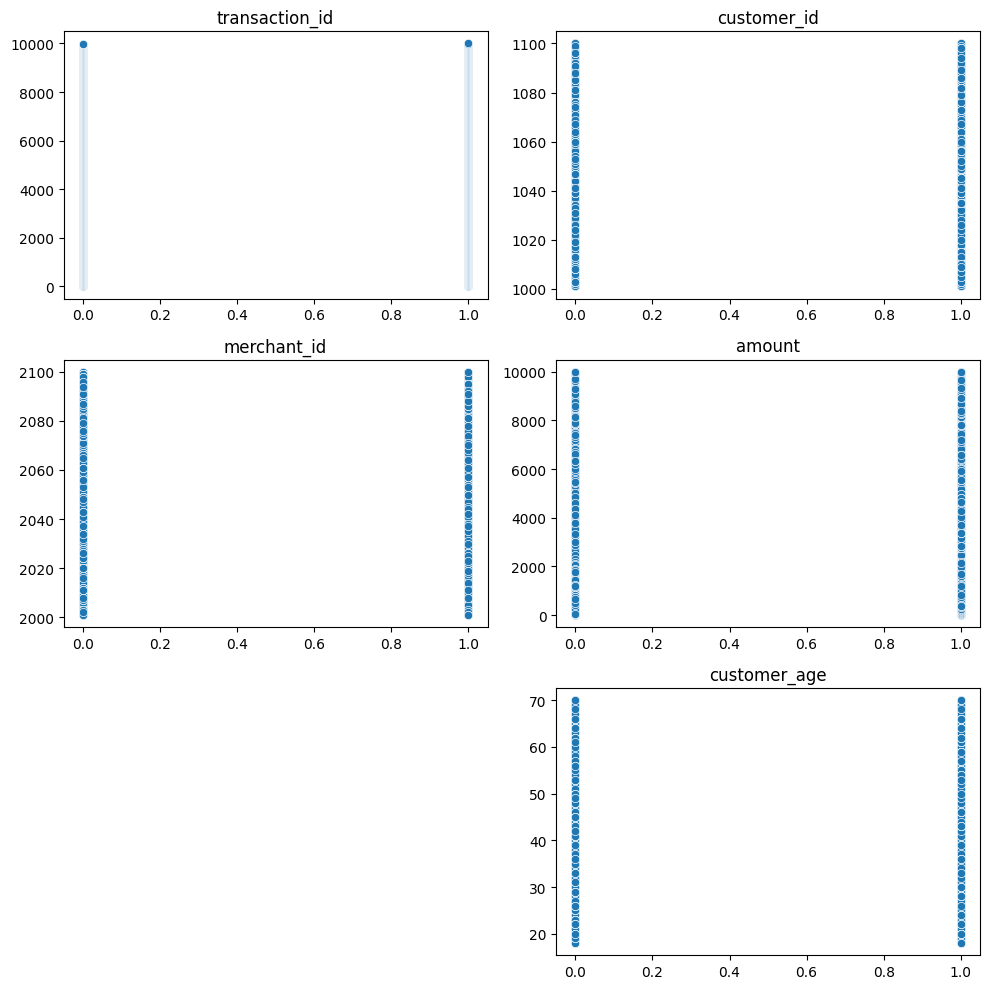

In [76]:
visualizar_outliers_bivariados(df,"is_fraudulent",(10,10))

# Local Outlier Forest


se ha hecho outlier_0.01_transaction_id_lof
se ha hecho outlier_0.01_customer_id_lof
se ha hecho outlier_0.01_merchant_id_lof
se ha hecho outlier_0.01_amount_lof
se ha hecho outlier_0.01_customer_age_lof


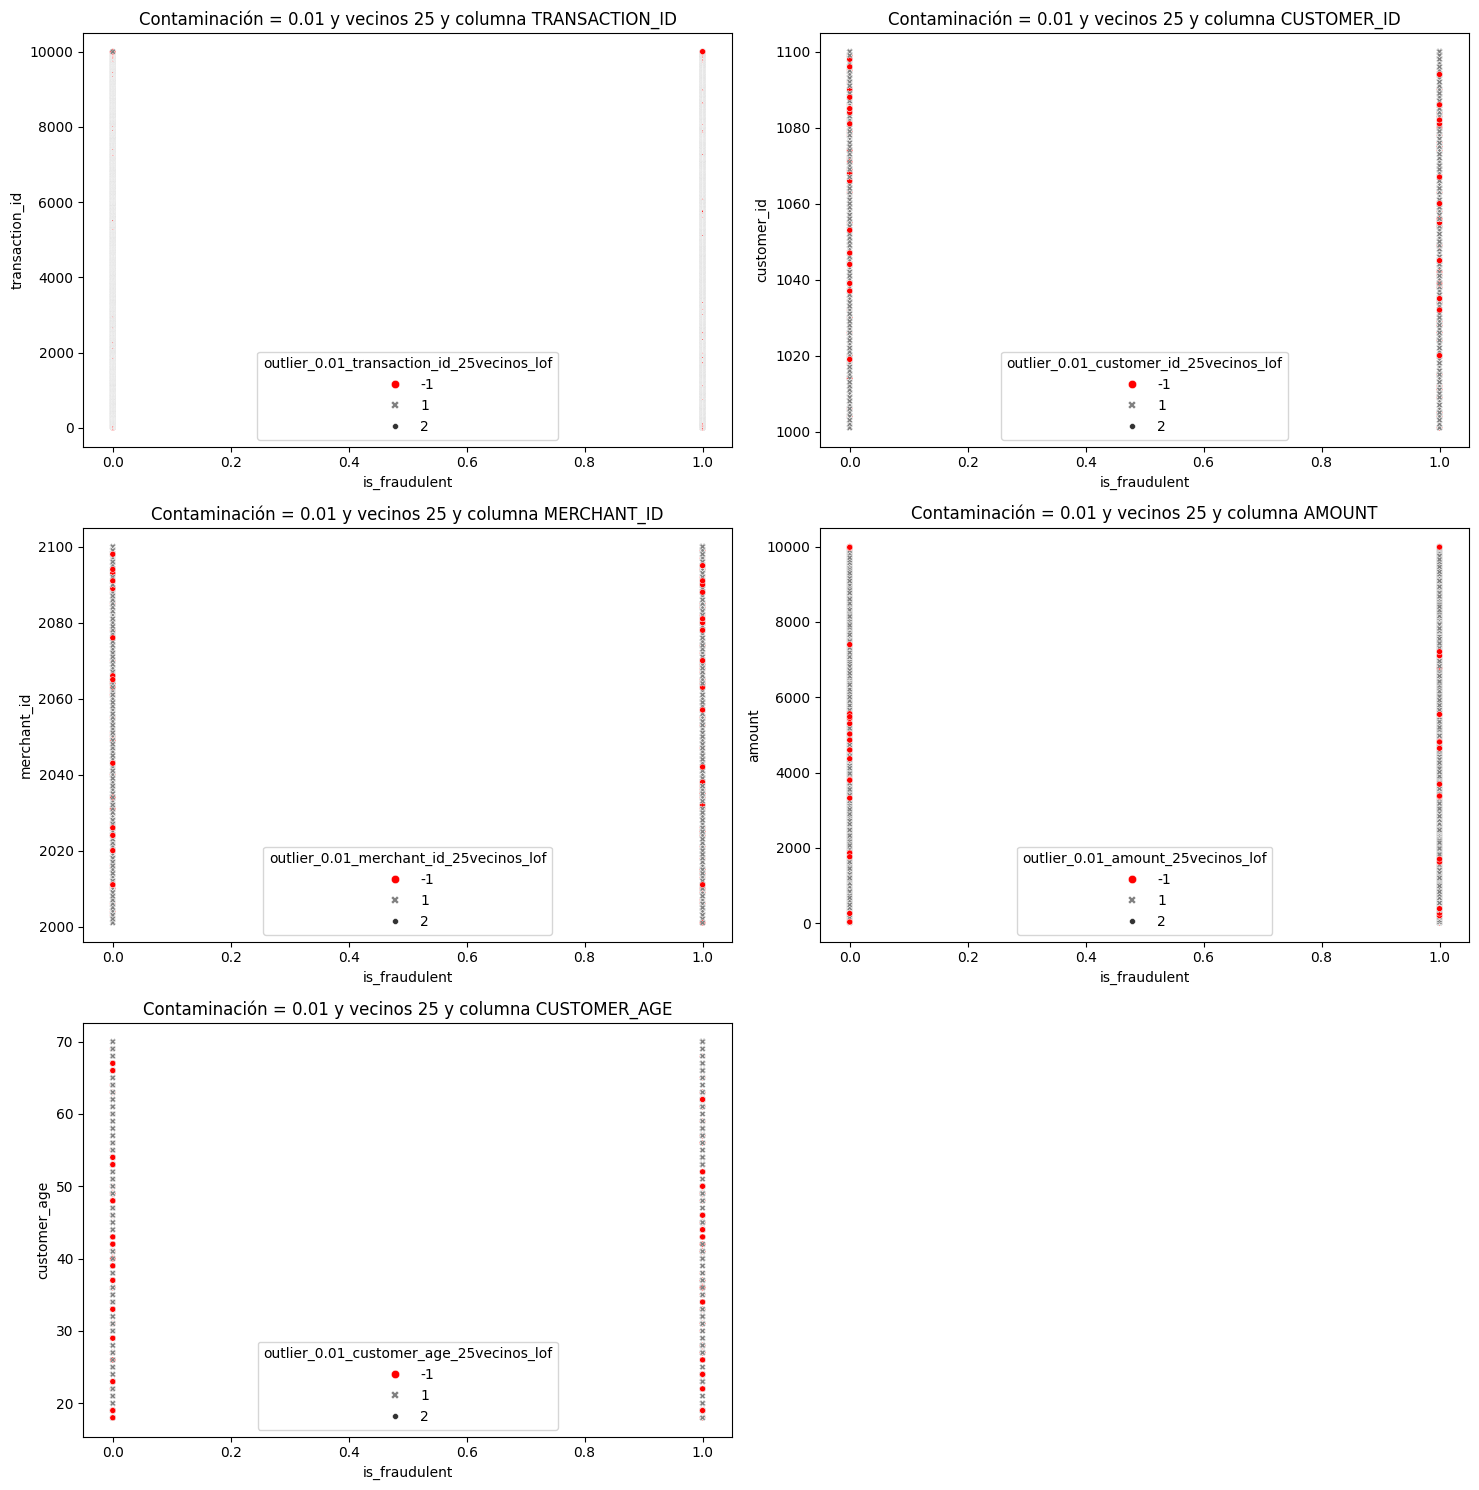

se ha hecho outlier_0.05_transaction_id_lof
se ha hecho outlier_0.05_customer_id_lof
se ha hecho outlier_0.05_merchant_id_lof
se ha hecho outlier_0.05_amount_lof
se ha hecho outlier_0.05_customer_age_lof


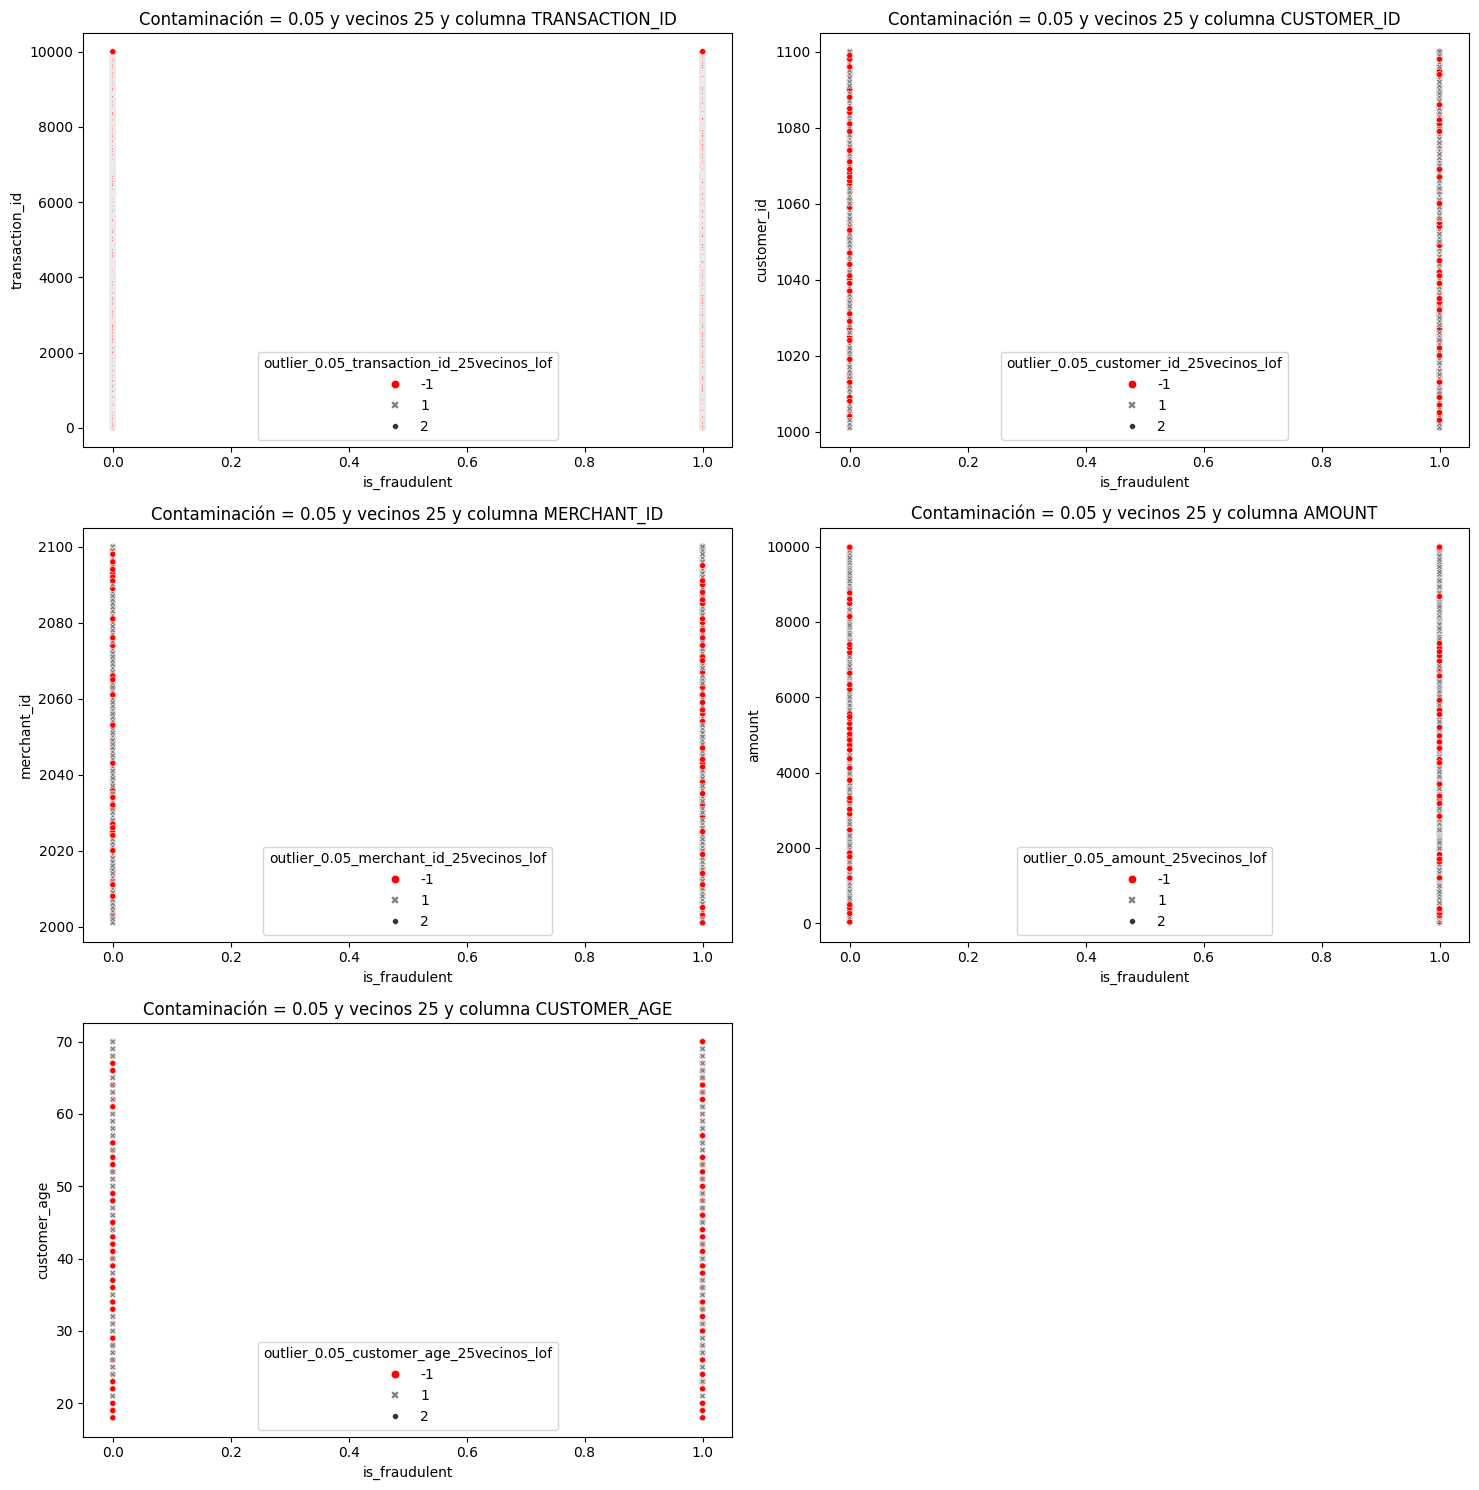

se ha hecho outlier_0.1_transaction_id_lof
se ha hecho outlier_0.1_customer_id_lof
se ha hecho outlier_0.1_merchant_id_lof
se ha hecho outlier_0.1_amount_lof
se ha hecho outlier_0.1_customer_age_lof


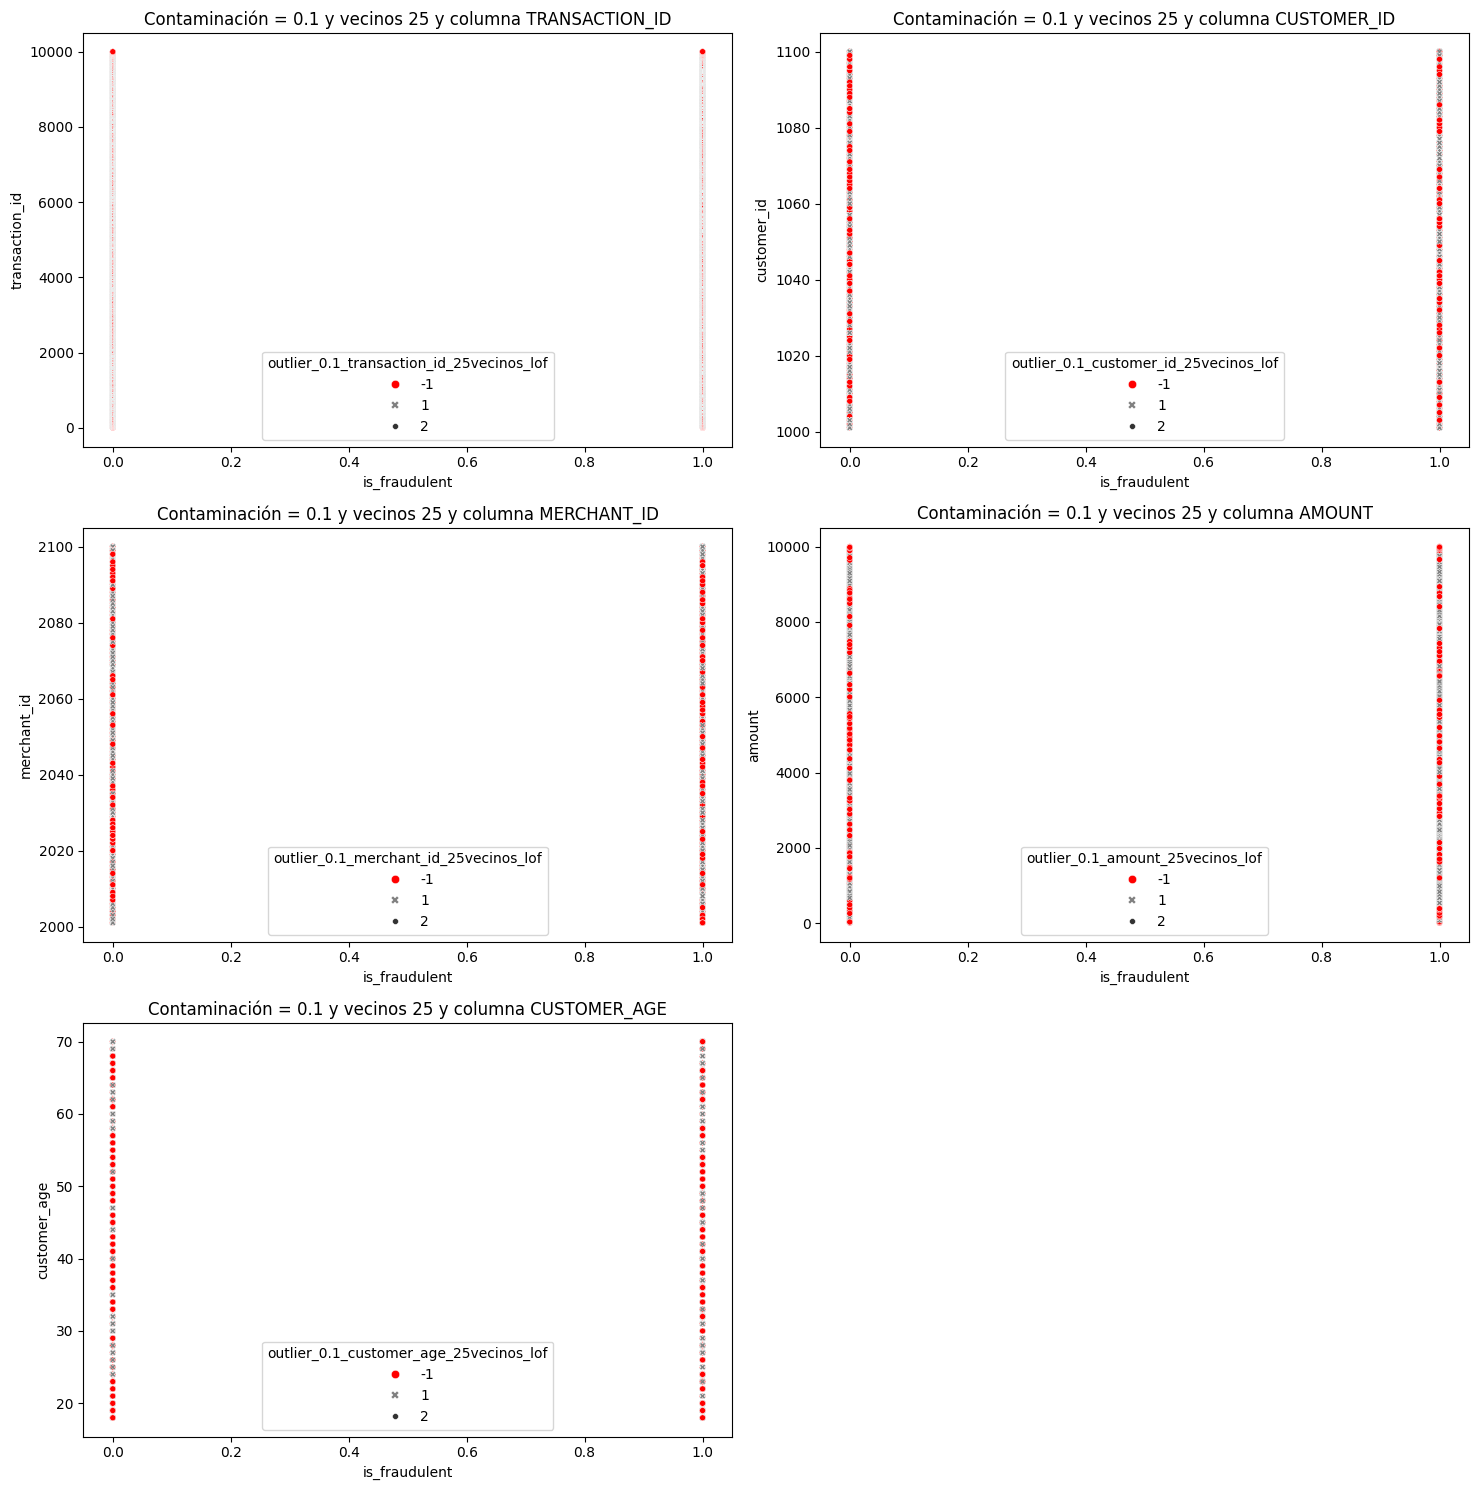

se ha hecho outlier_0.01_transaction_id_lof
se ha hecho outlier_0.01_customer_id_lof
se ha hecho outlier_0.01_merchant_id_lof
se ha hecho outlier_0.01_amount_lof
se ha hecho outlier_0.01_customer_age_lof


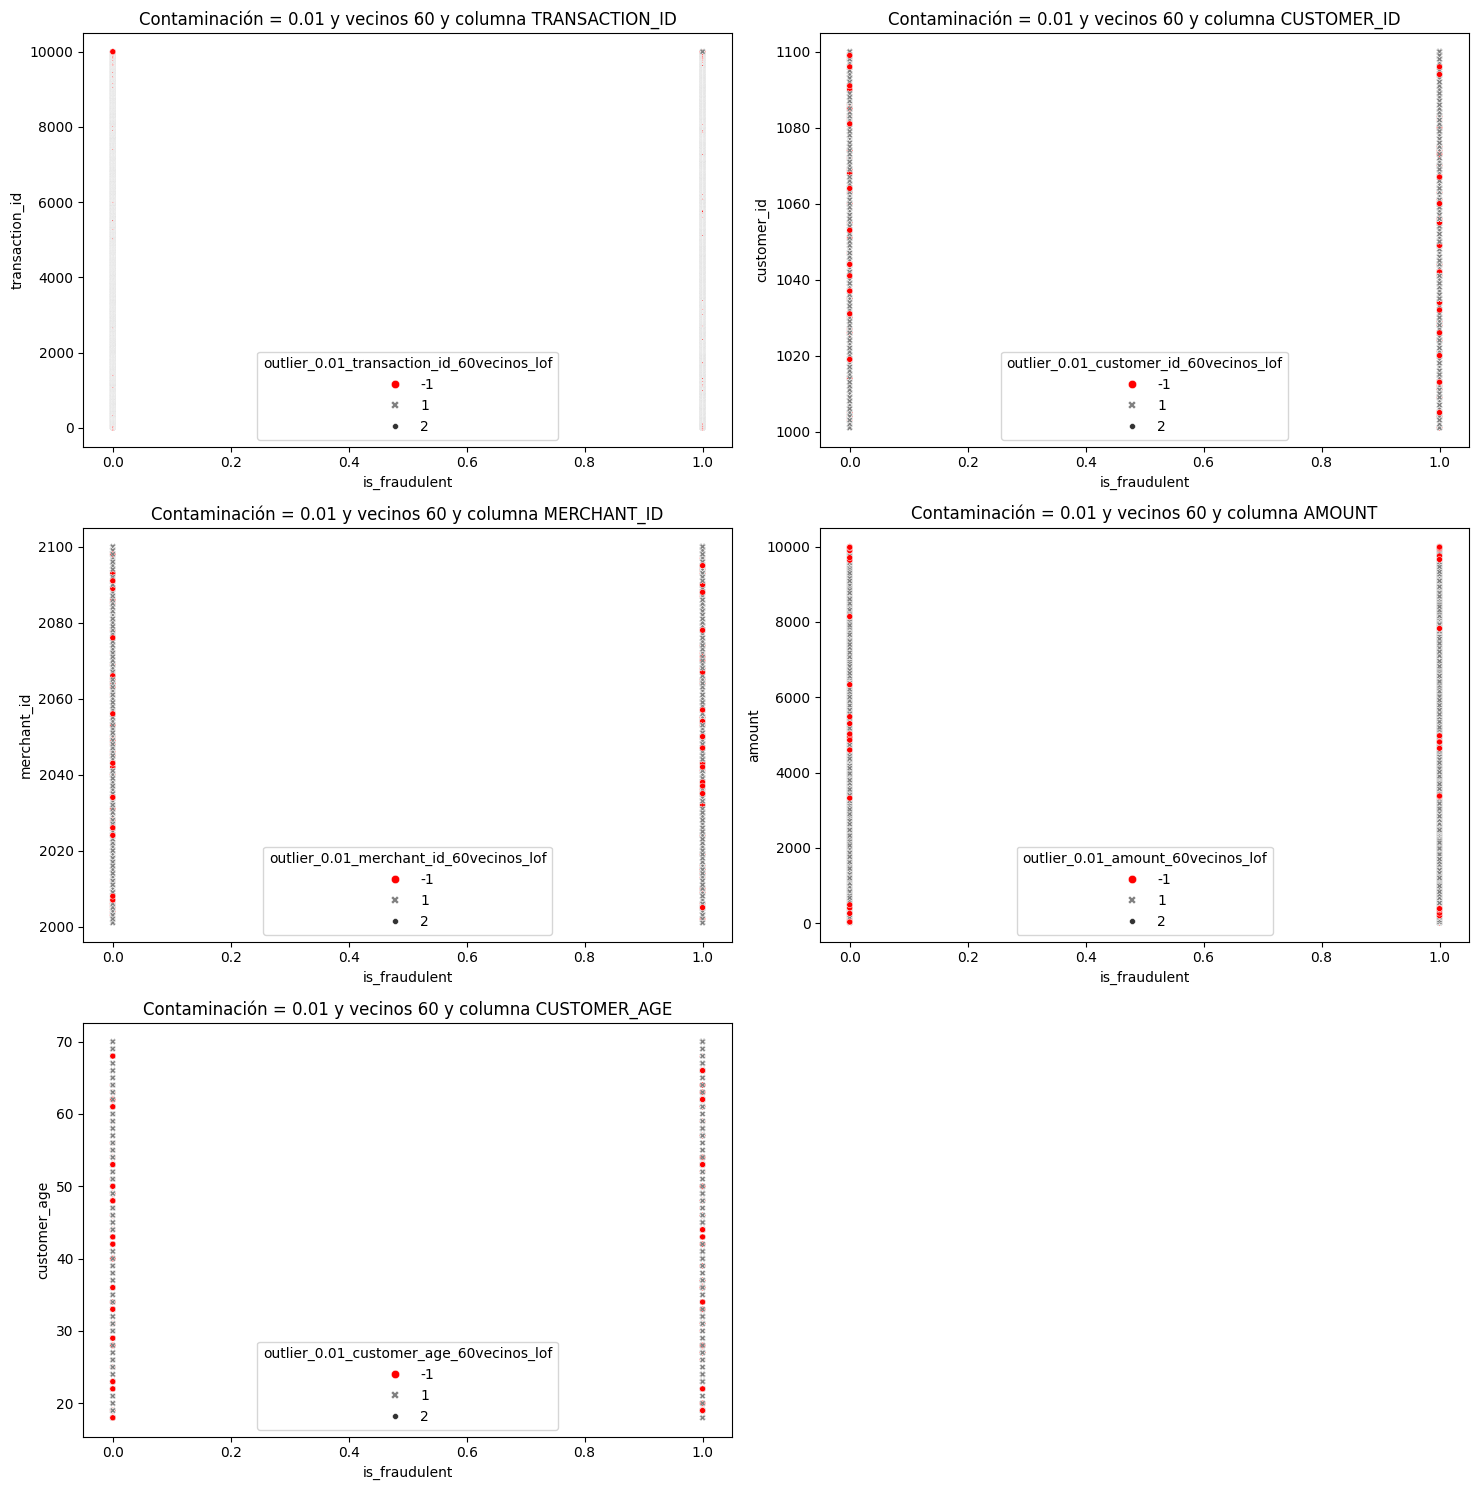

se ha hecho outlier_0.05_transaction_id_lof
se ha hecho outlier_0.05_customer_id_lof
se ha hecho outlier_0.05_merchant_id_lof
se ha hecho outlier_0.05_amount_lof
se ha hecho outlier_0.05_customer_age_lof


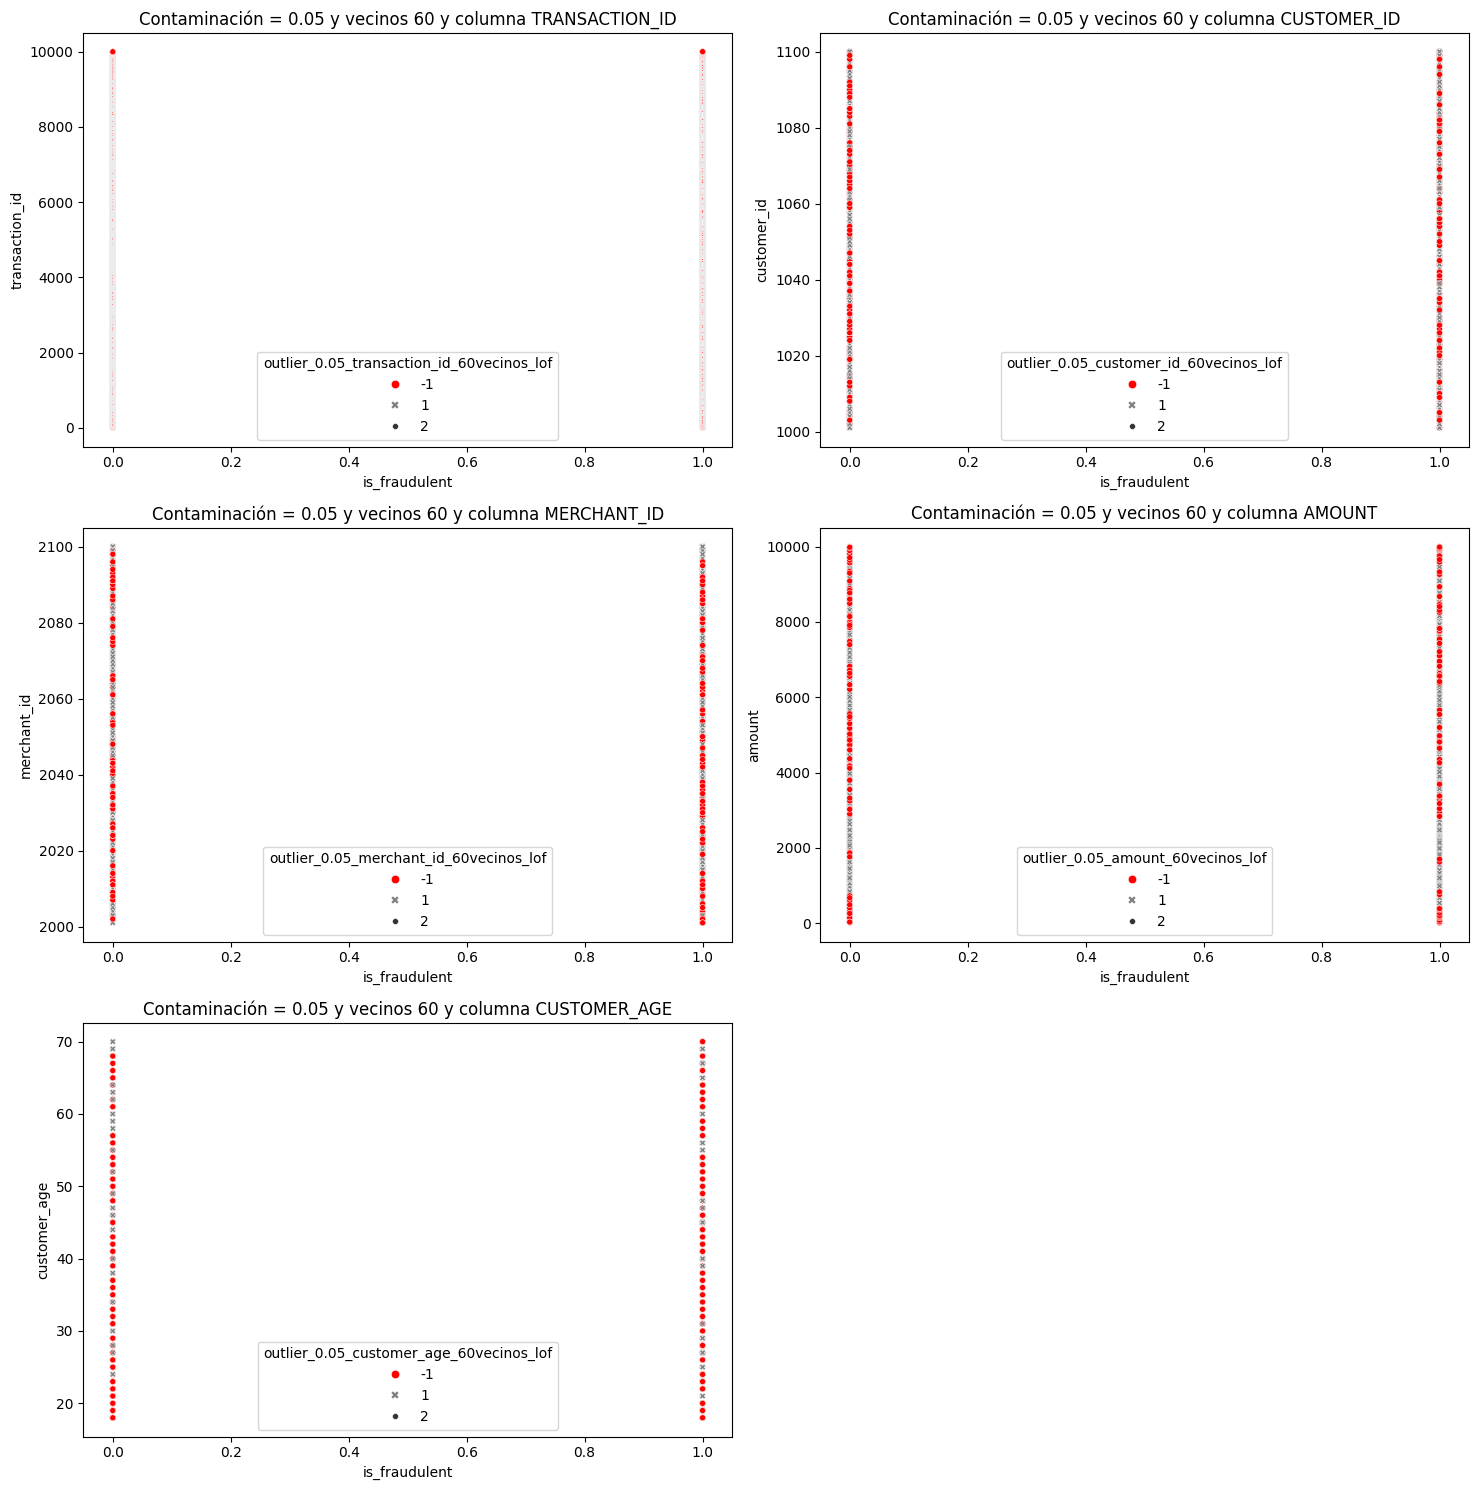

se ha hecho outlier_0.1_transaction_id_lof
se ha hecho outlier_0.1_customer_id_lof
se ha hecho outlier_0.1_merchant_id_lof
se ha hecho outlier_0.1_amount_lof
se ha hecho outlier_0.1_customer_age_lof


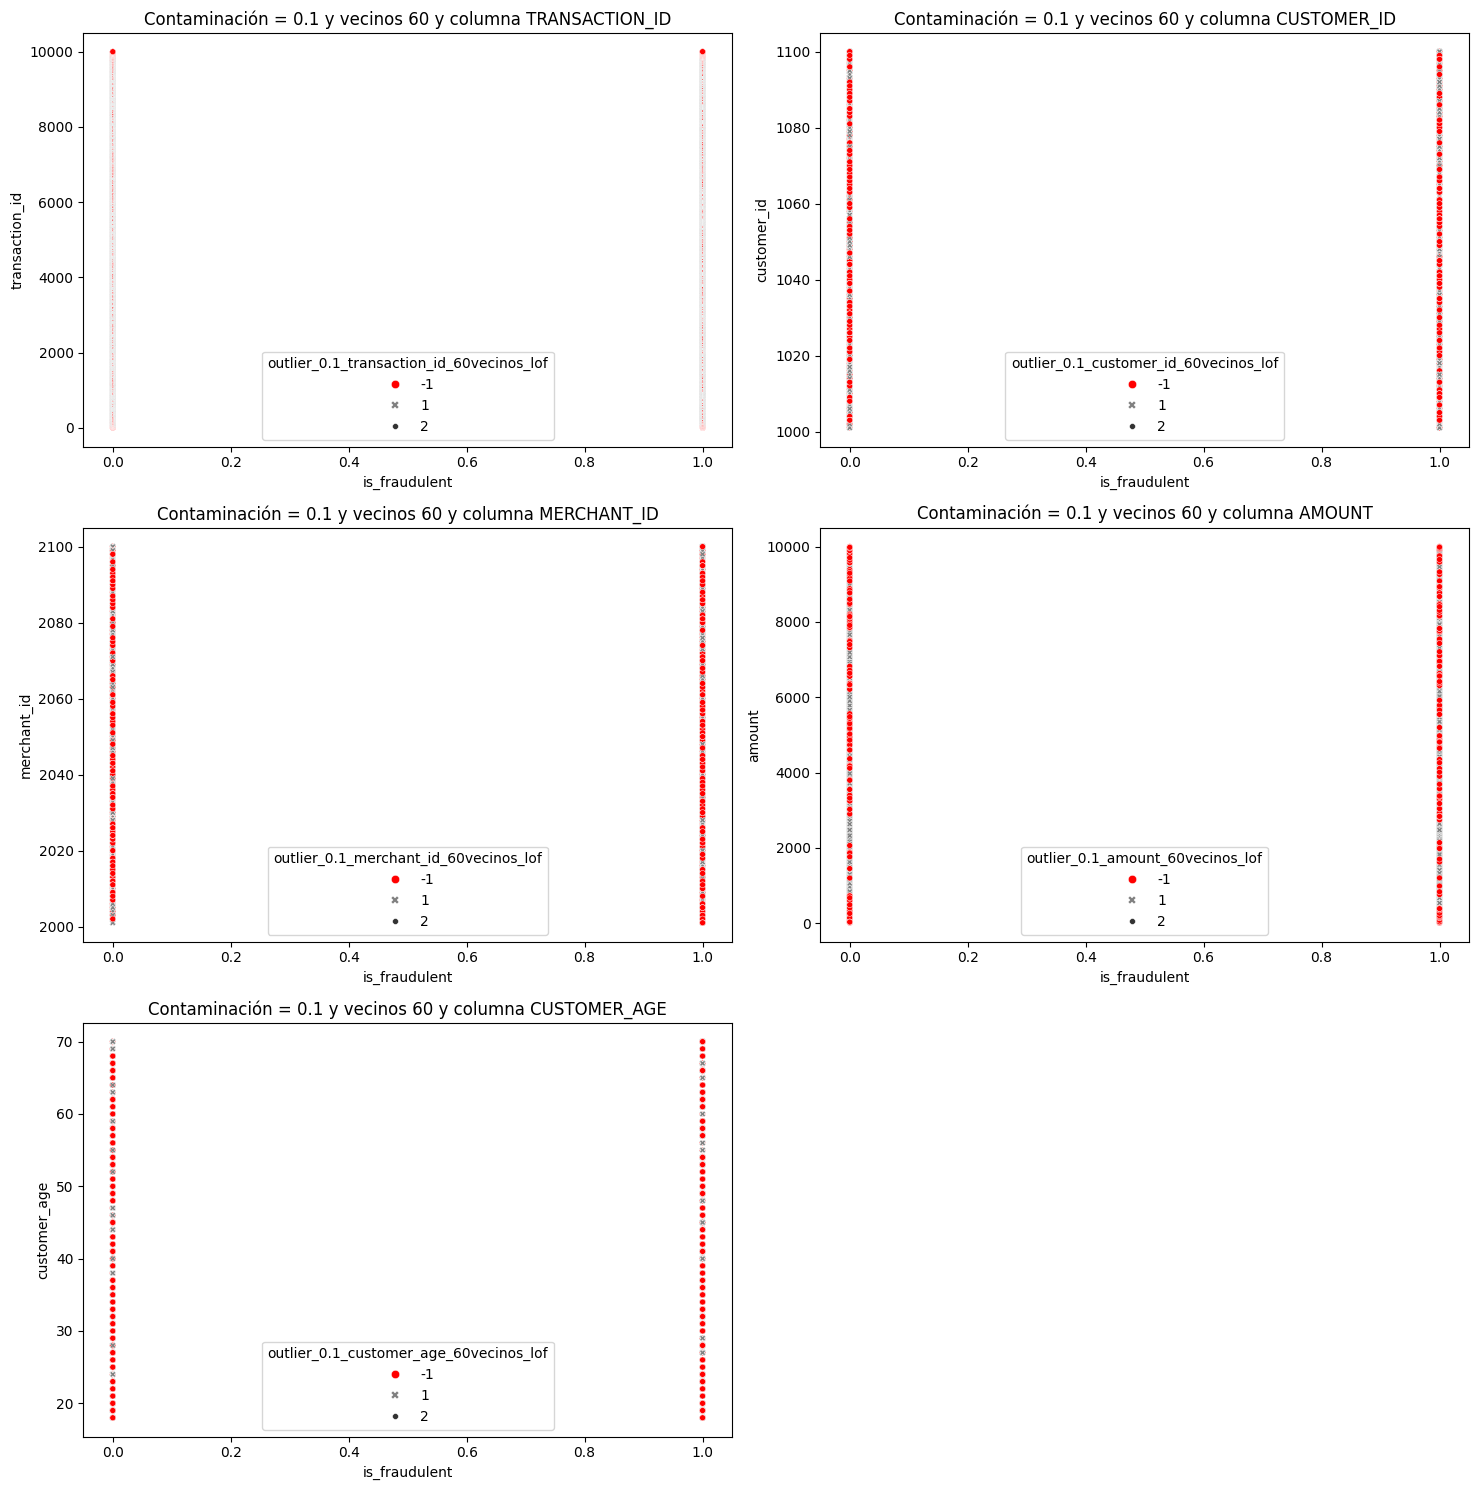

se ha hecho outlier_0.01_transaction_id_lof
se ha hecho outlier_0.01_customer_id_lof
se ha hecho outlier_0.01_merchant_id_lof
se ha hecho outlier_0.01_amount_lof
se ha hecho outlier_0.01_customer_age_lof


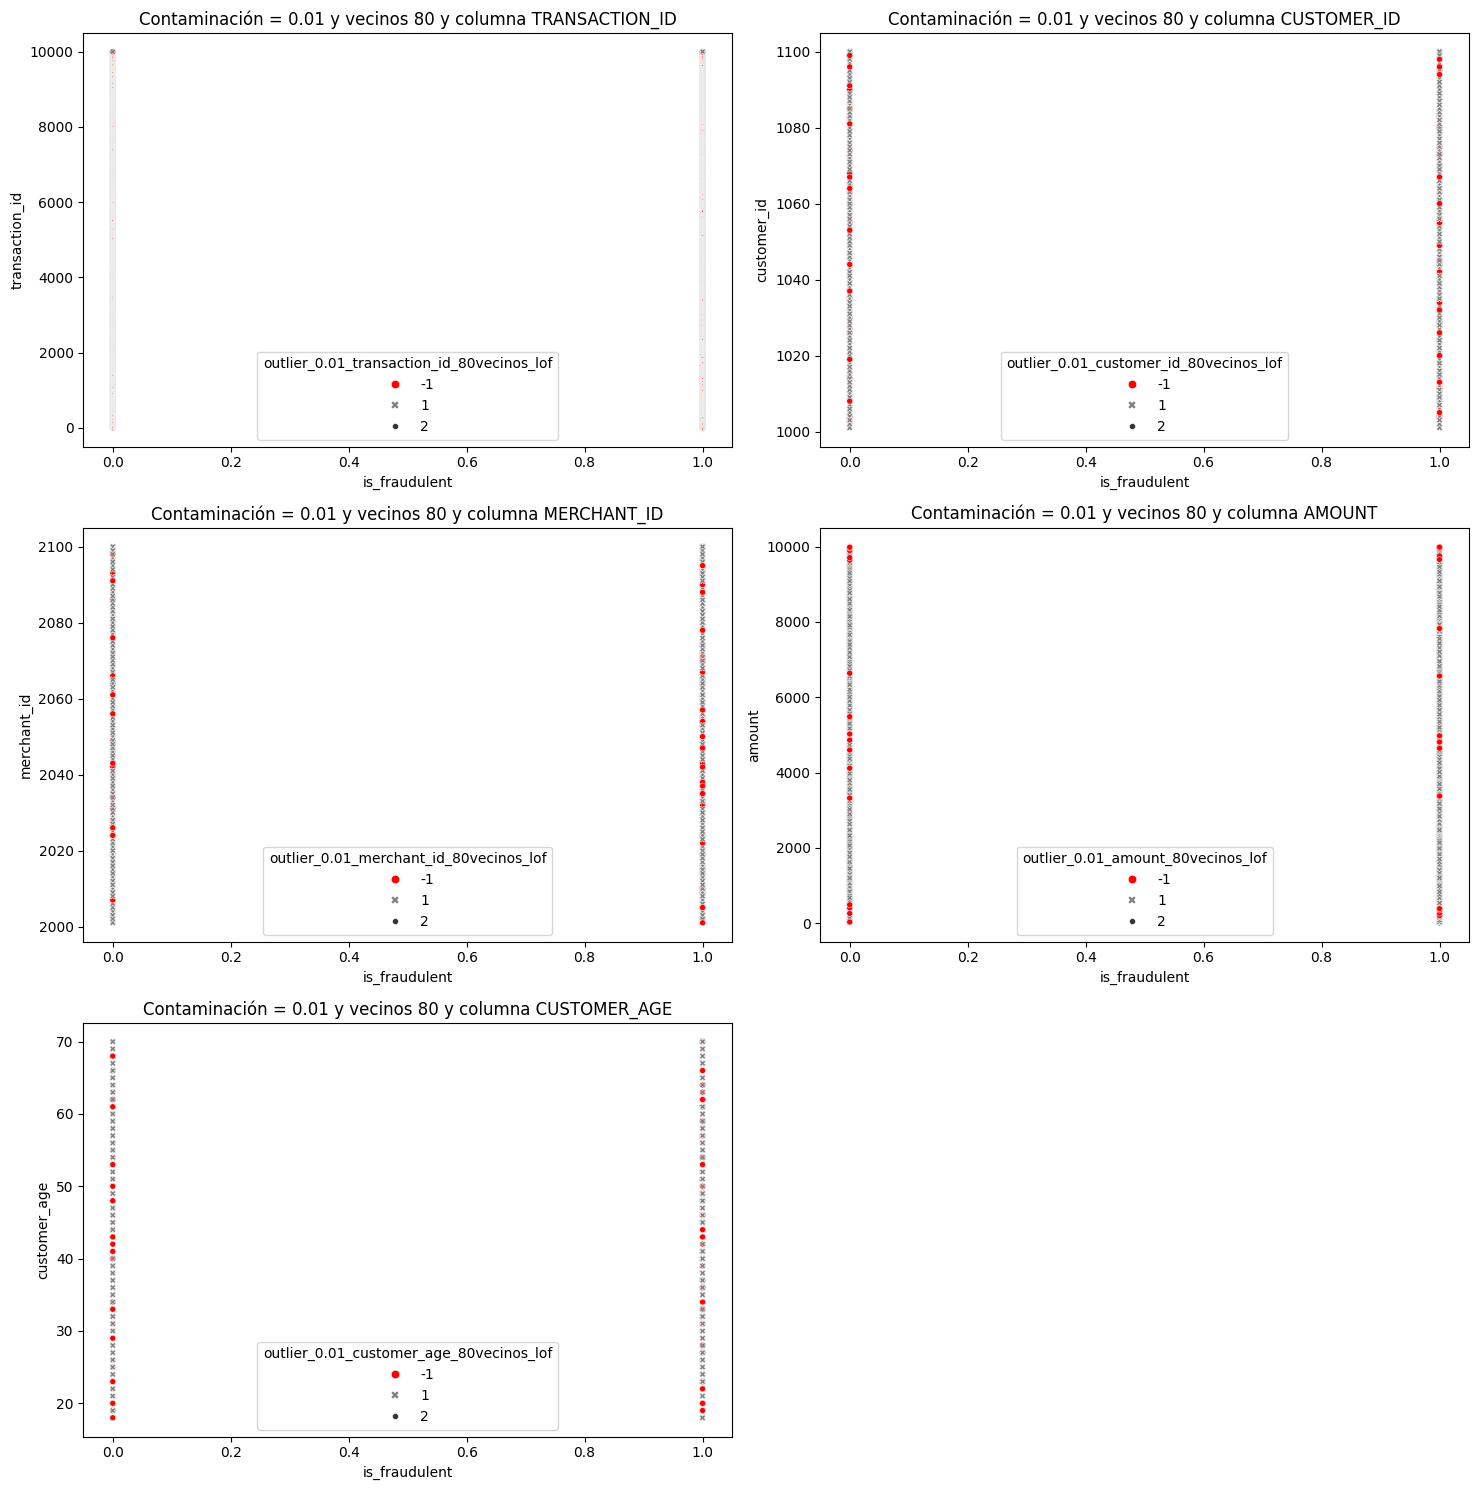

se ha hecho outlier_0.05_transaction_id_lof
se ha hecho outlier_0.05_customer_id_lof
se ha hecho outlier_0.05_merchant_id_lof
se ha hecho outlier_0.05_amount_lof
se ha hecho outlier_0.05_customer_age_lof


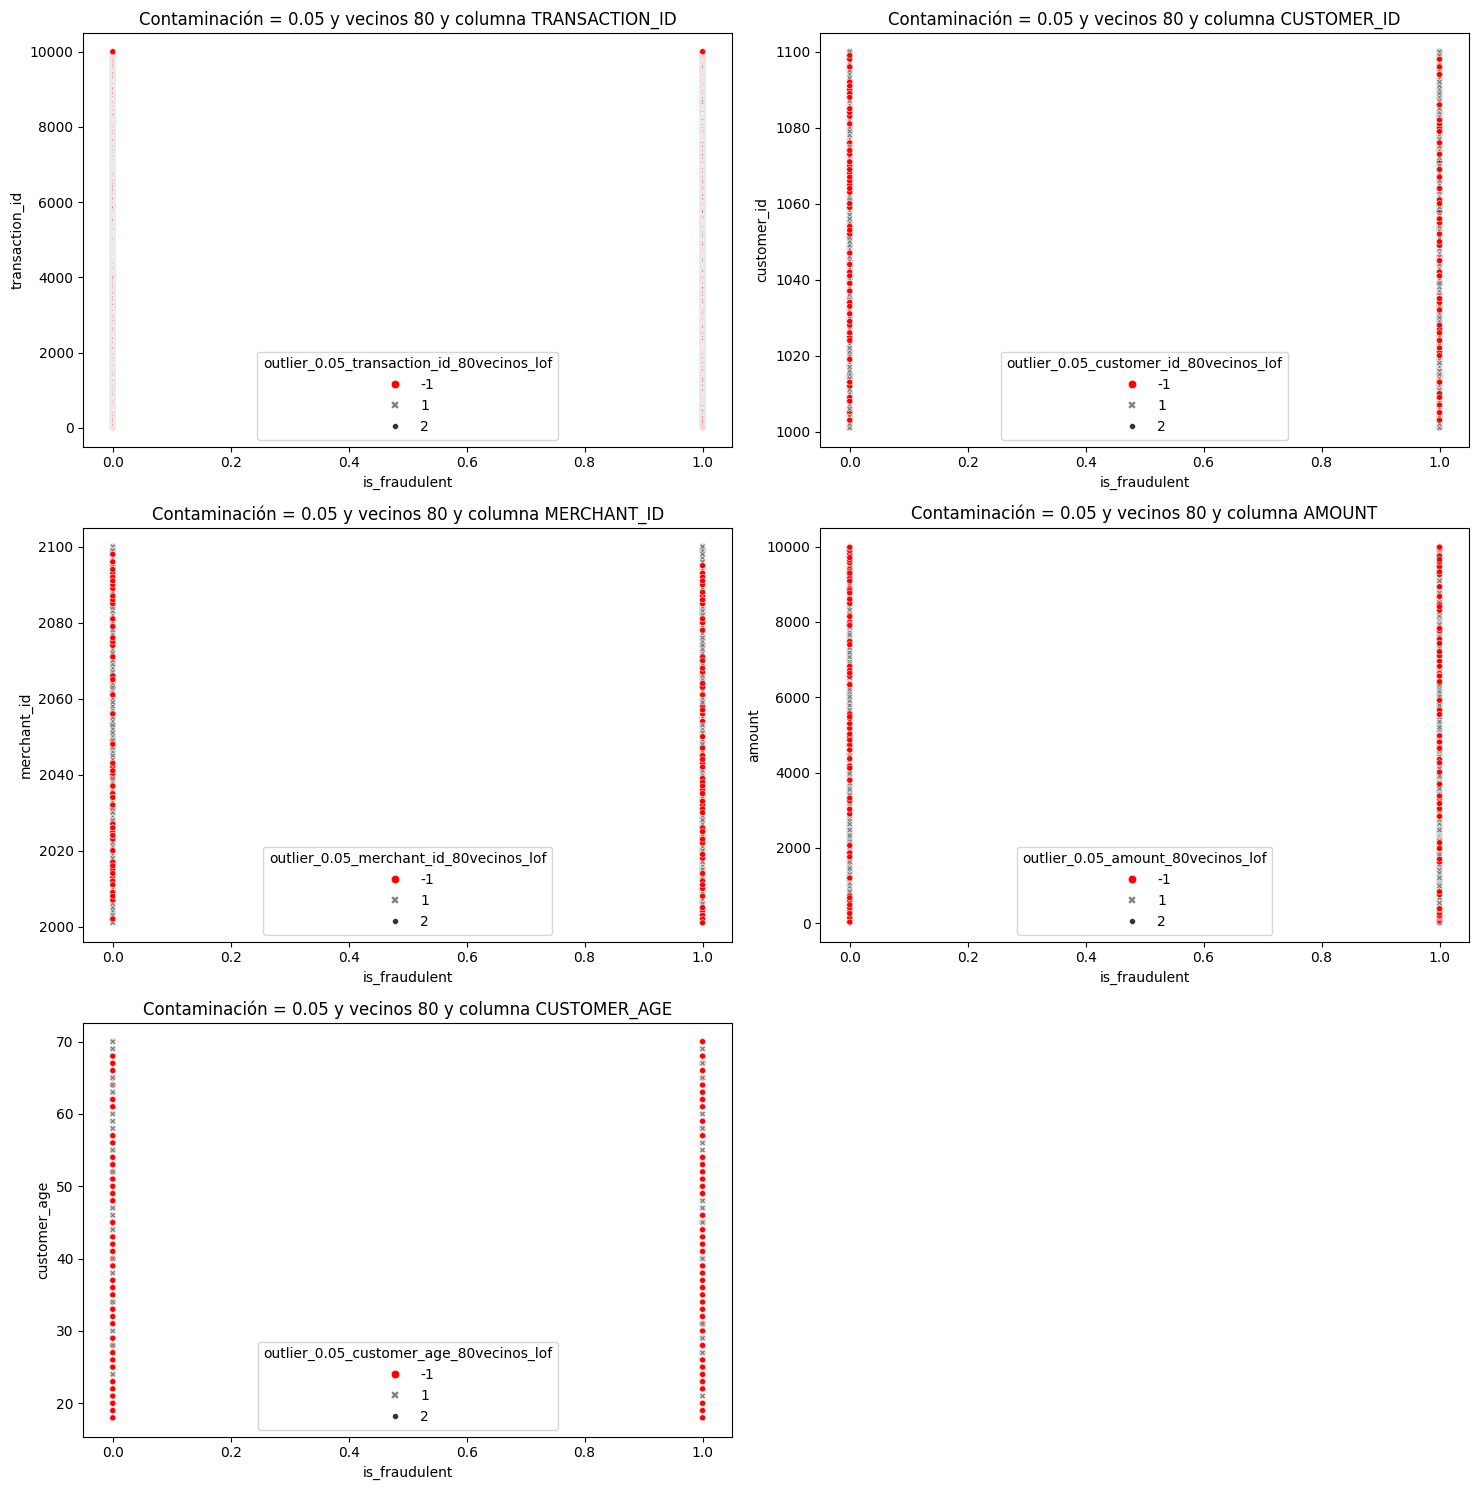

se ha hecho outlier_0.1_transaction_id_lof
se ha hecho outlier_0.1_customer_id_lof
se ha hecho outlier_0.1_merchant_id_lof
se ha hecho outlier_0.1_amount_lof
se ha hecho outlier_0.1_customer_age_lof


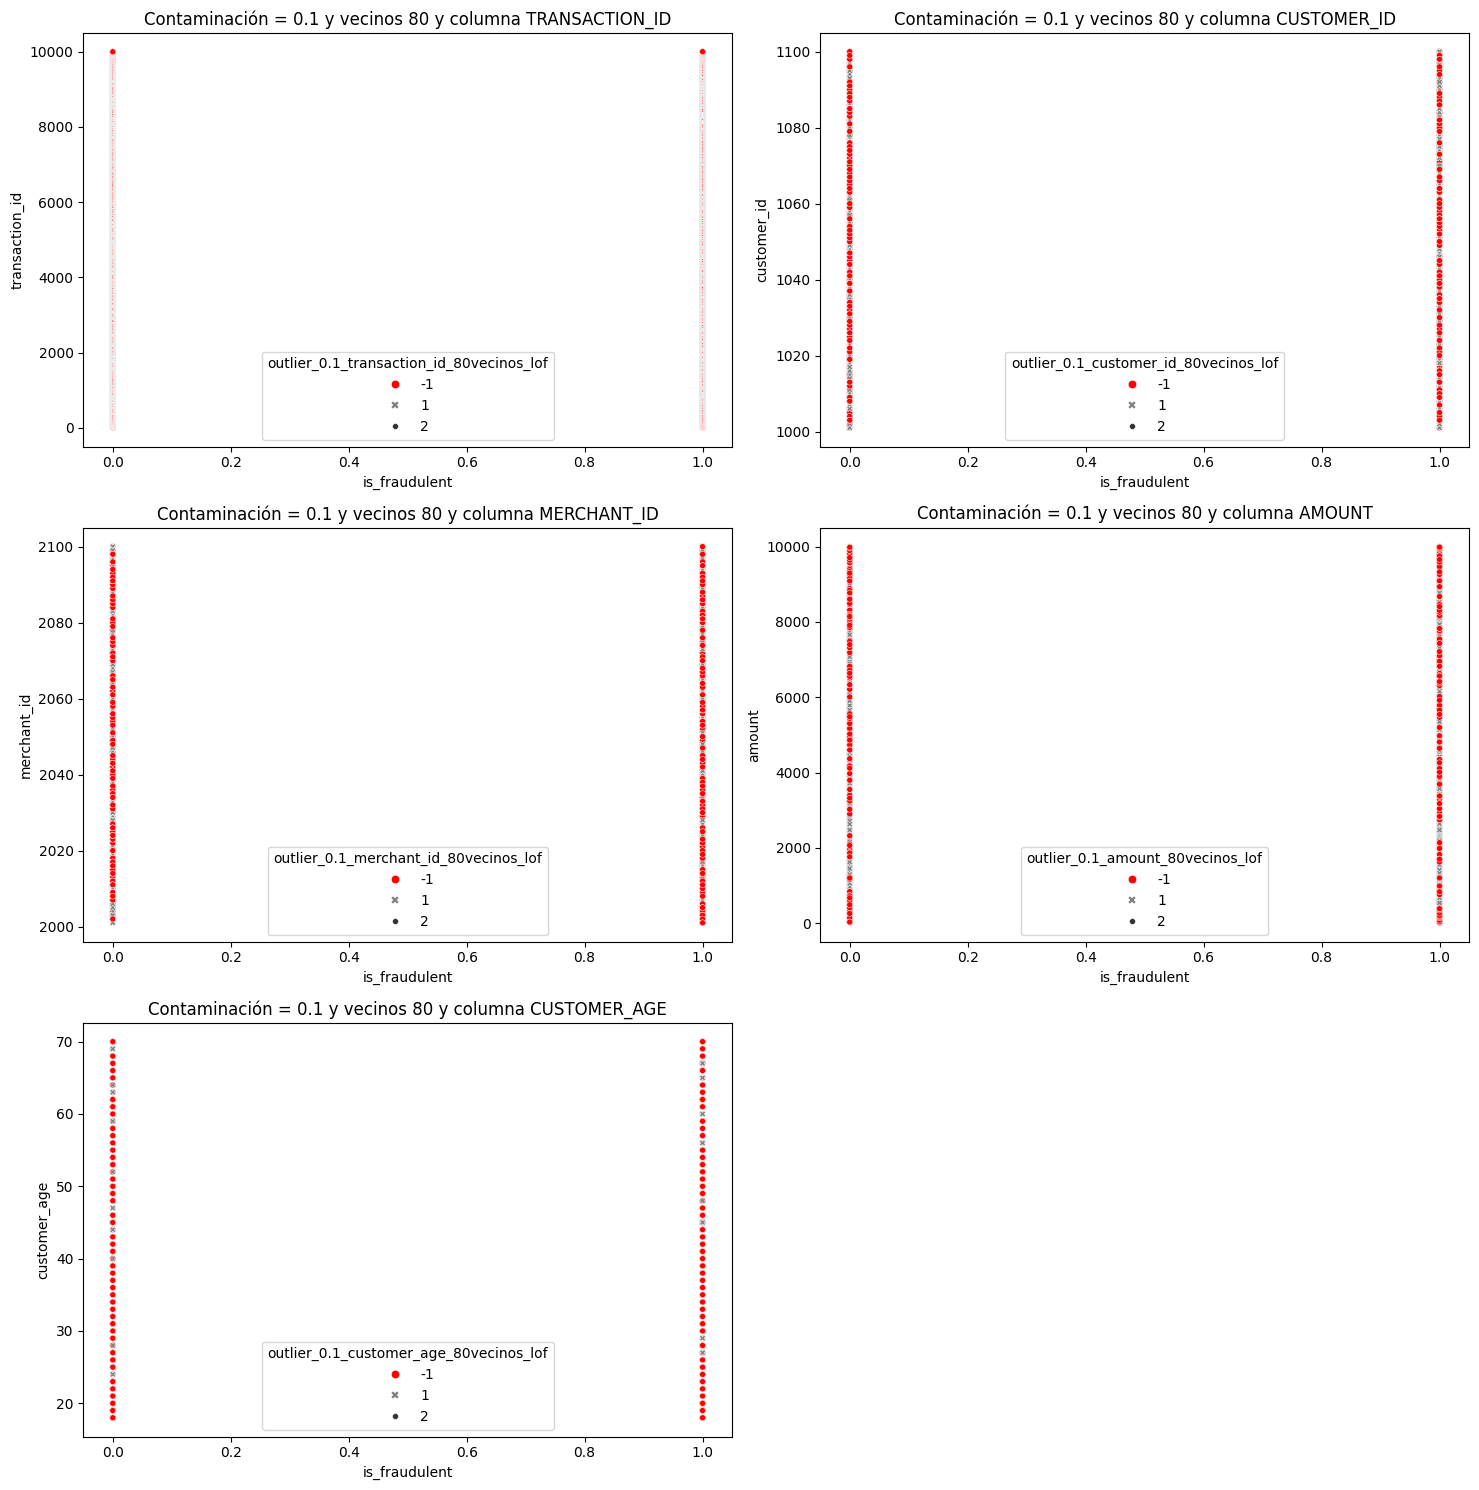

Se devuelve df Modificado


In [77]:
df_lof = explorar_outliers_lof(df,df,"is_fraudulent",vecinos=[25,60,80],grafica_size=(15,15))

In [78]:
df_lof.sample()

,transaction_id,customer_id,merchant_id,amount,is_fraudulent,card_type,location,purchase_category,customer_age,transaction_description,outlier_0.01_transaction_id_25vecinos_lof,outlier_0.01_customer_id_25vecinos_lof,outlier_0.01_merchant_id_25vecinos_lof,outlier_0.01_amount_25vecinos_lof,outlier_0.01_customer_age_25vecinos_lof,outlier_0.05_transaction_id_25vecinos_lof,outlier_0.05_customer_id_25vecinos_lof,outlier_0.05_merchant_id_25vecinos_lof,outlier_0.05_amount_25vecinos_lof,outlier_0.05_customer_age_25vecinos_lof,outlier_0.1_transaction_id_25vecinos_lof,outlier_0.1_customer_id_25vecinos_lof,outlier_0.1_merchant_id_25vecinos_lof,outlier_0.1_amount_25vecinos_lof,outlier_0.1_customer_age_25vecinos_lof,outlier_0.01_transaction_id_60vecinos_lof,outlier_0.01_customer_id_60vecinos_lof,outlier_0.01_merchant_id_60vecinos_lof,outlier_0.01_amount_60vecinos_lof,outlier_0.01_customer_age_60vecinos_lof,outlier_0.05_transaction_id_60vecinos_lof,outlier_0.05_customer_id_60vecinos_lof,outlier_0.05_merchant_id_60vecinos_lof,outlier_0.05_amount_60vecinos_lof,outlier_0.05_customer_age_60vecinos_lof,outlier_0.1_transaction_id_60vecinos_lof,outlier_0.1_customer_id_60vecinos_lof,outlier_0.1_merchant_id_60vecinos_lof,outlier_0.1_amount_60vecinos_lof,outlier_0.1_customer_age_60vecinos_lof,outlier_0.01_transaction_id_80vecinos_lof,outlier_0.01_customer_id_80vecinos_lof,outlier_0.01_merchant_id_80vecinos_lof,outlier_0.01_amount_80vecinos_lof,outlier_0.01_customer_age_80vecinos_lof,outlier_0.05_transaction_id_80vecinos_lof,outlier_0.05_customer_id_80vecinos_lof,outlier_0.05_merchant_id_80vecinos_lof,outlier_0.05_amount_80vecinos_lof,outlier_0.05_customer_age_80vecinos_lof,outlier_0.1_transaction_id_80vecinos_lof,outlier_0.1_customer_id_80vecinos_lof,outlier_0.1_merchant_id_80vecinos_lof,outlier_0.1_amount_80vecinos_lof,outlier_0.1_customer_age_80vecinos_lof
979,980,1096,2093,373.8,0,American Express,City-50,Travel,23,Purchase at Merchant-2093,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


# Isolation Forest

se ha hecho outlier_0.01_customer_age_isoforest
se ha hecho outlier_0.05_customer_age_isoforest
se ha hecho outlier_0.1_customer_age_isoforest
Se devuelve df Modificado


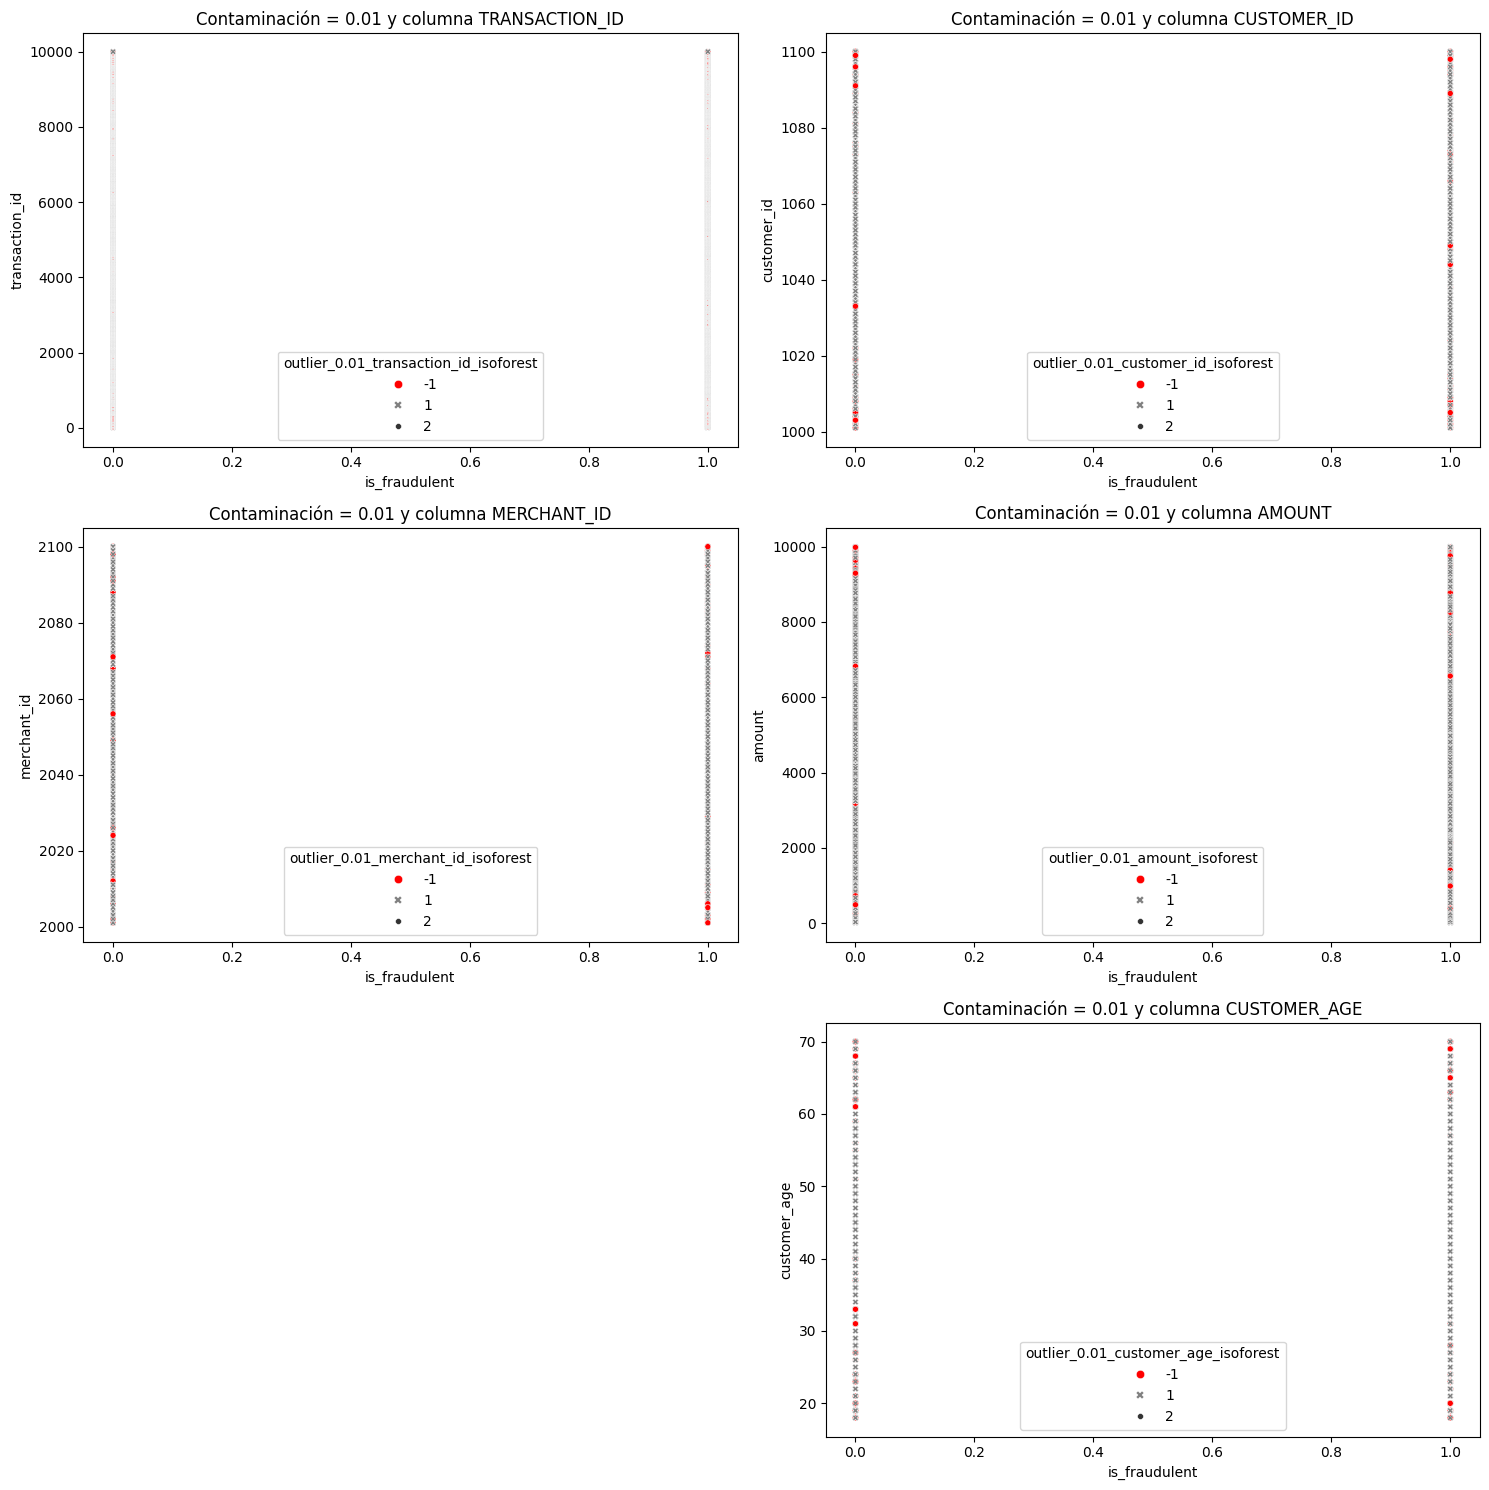

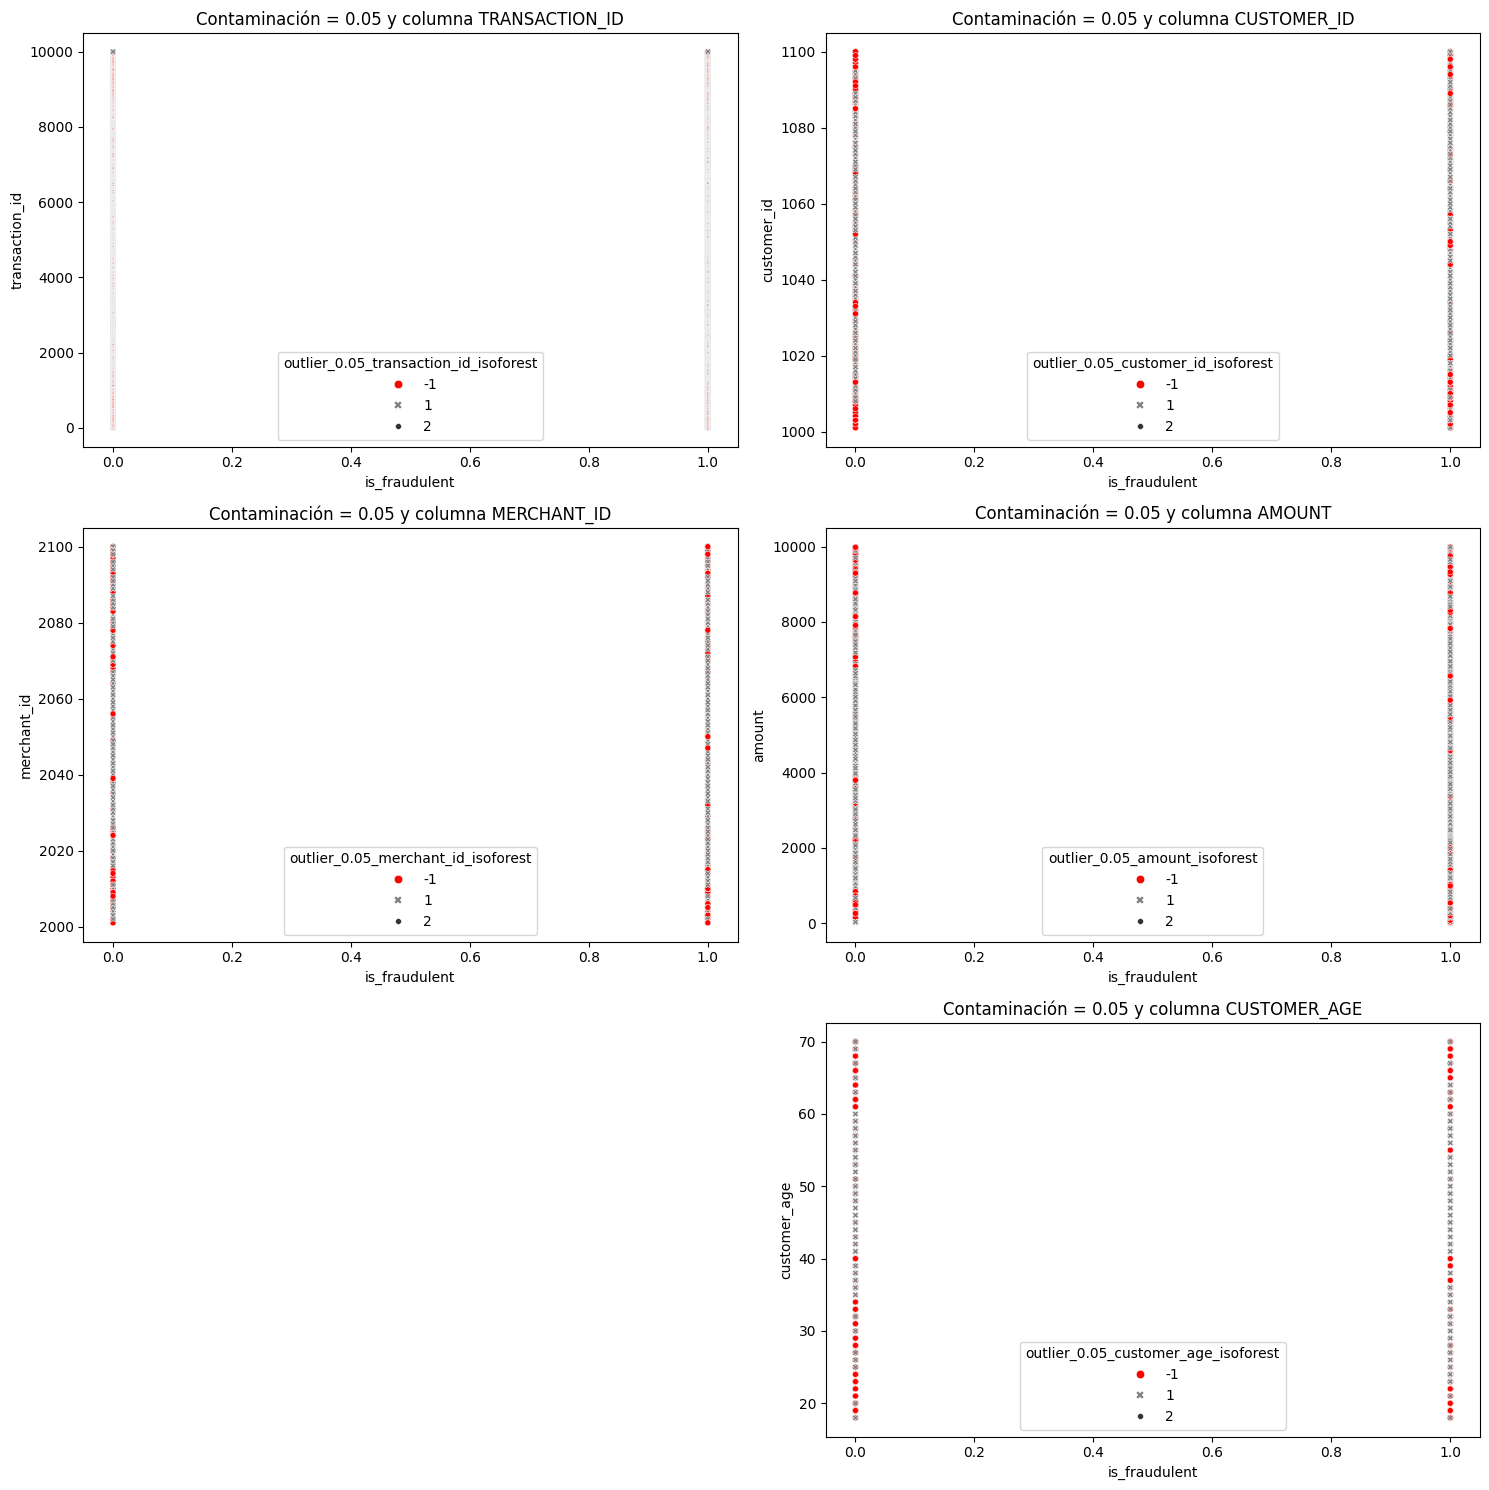

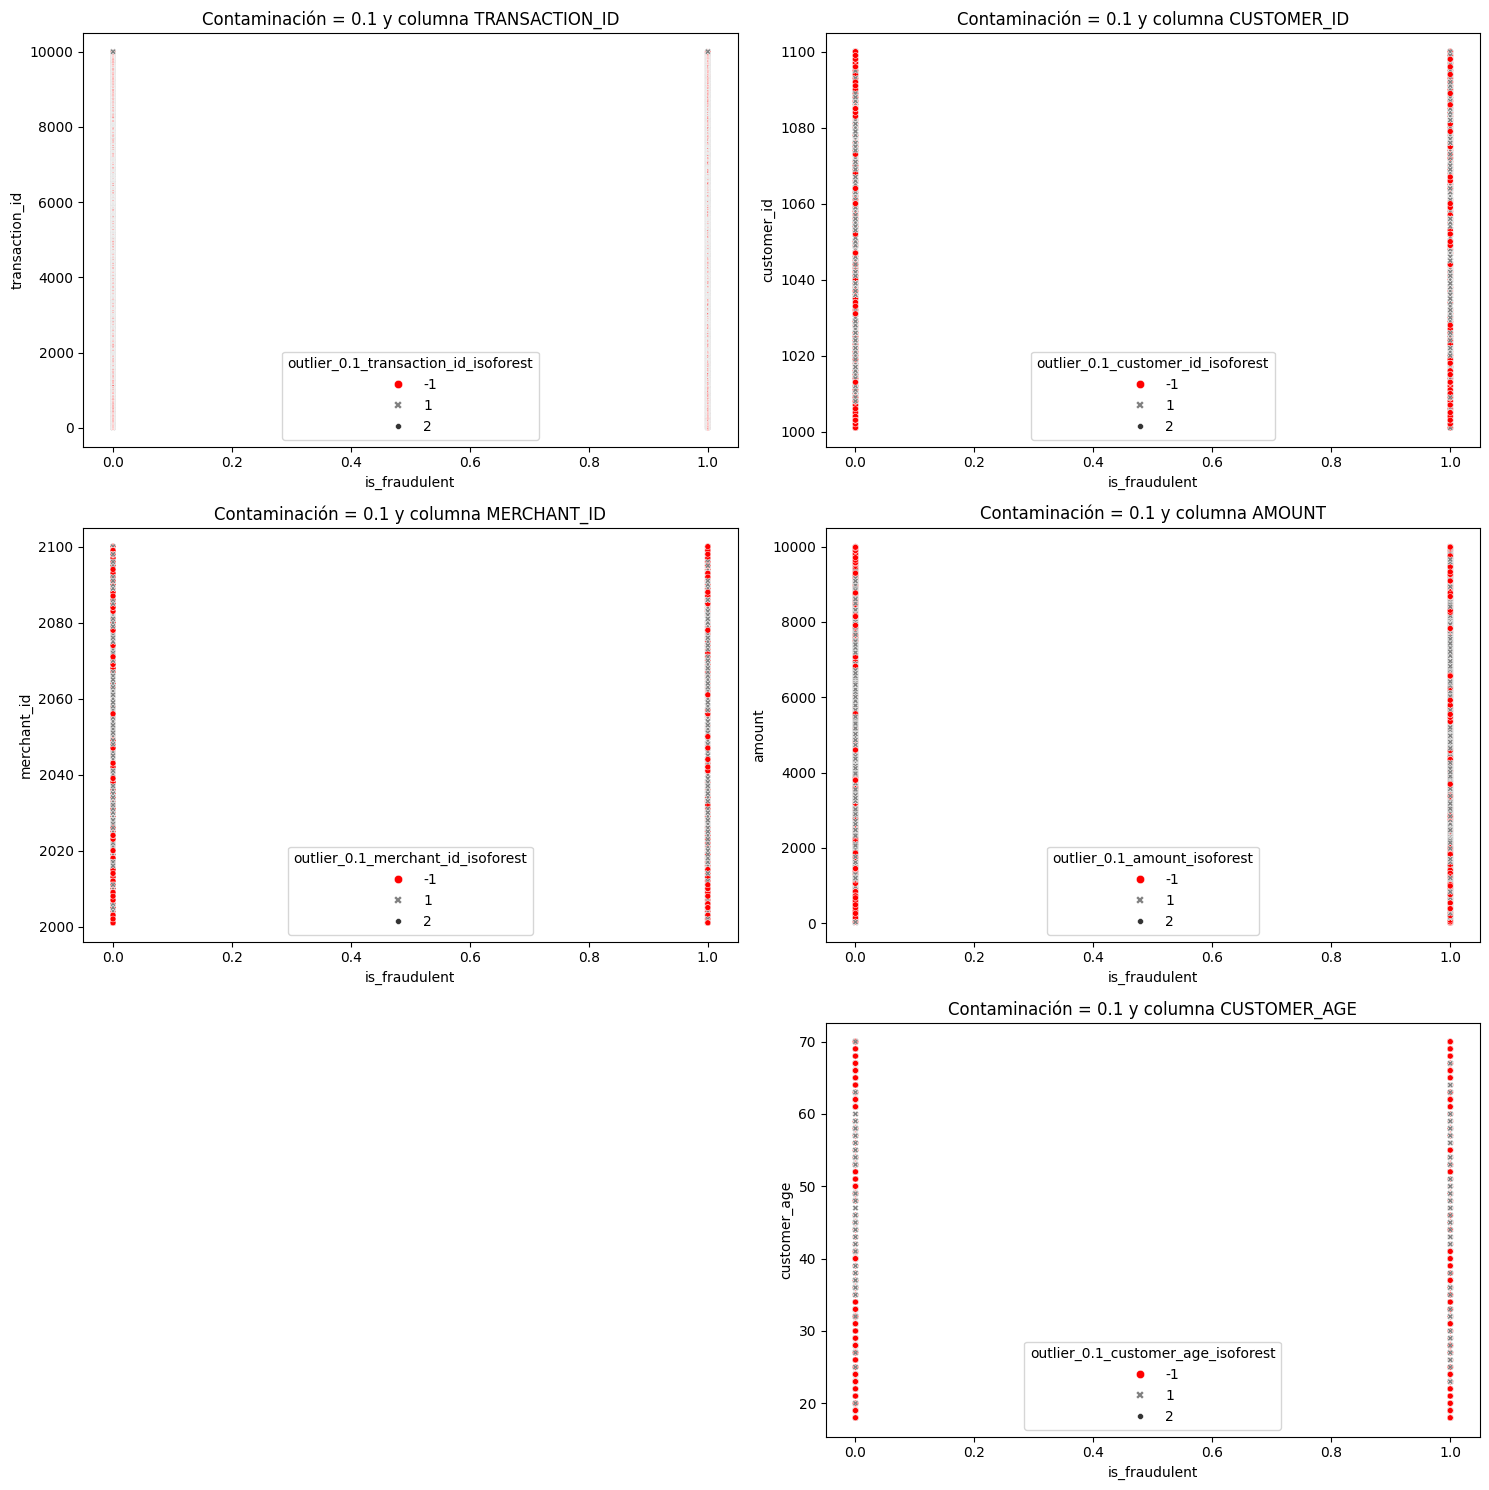

In [79]:
df_iso = explorar_outliers_if(df,df,"is_fraudulent",grafica_size=(15,15))

In [80]:
df_iso.sample()

,transaction_id,customer_id,merchant_id,amount,is_fraudulent,card_type,location,purchase_category,customer_age,transaction_description,outlier_0.01_transaction_id_isoforest,outlier_0.01_customer_id_isoforest,outlier_0.01_merchant_id_isoforest,outlier_0.01_amount_isoforest,outlier_0.01_is_fraudulent_isoforest,outlier_0.01_customer_age_isoforest,outlier_0.05_transaction_id_isoforest,outlier_0.05_customer_id_isoforest,outlier_0.05_merchant_id_isoforest,outlier_0.05_amount_isoforest,outlier_0.05_is_fraudulent_isoforest,outlier_0.05_customer_age_isoforest,outlier_0.1_transaction_id_isoforest,outlier_0.1_customer_id_isoforest,outlier_0.1_merchant_id_isoforest,outlier_0.1_amount_isoforest,outlier_0.1_is_fraudulent_isoforest,outlier_0.1_customer_age_isoforest
1629,1630,1014,2084,4773.58,1,MasterCard,City-43,Online Shopping,30,Purchase at Merchant-2084,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


# LOF

In [81]:
len(df_lof.filter(like="outlier_").columns)

45

In [82]:
# Generamos nueva columna
df_lof["tipo_outliers"] = 0

# Contamos cuantos -1 hay
for columna in df_lof.filter(like="outlier").columns:
    df_lof["tipo_outliers"] += (df_lof[columna] == -1).astype(int)

# Generamos el diccionario de condiciones y textos para reemplazar
condiciones = [
    df_lof["tipo_outliers"] == 0,
    df_lof["tipo_outliers"].between(1, 27,"both"),
    df_lof["tipo_outliers"].between(28, 44,"both"),
    df_lof["tipo_outliers"] == 45
]

textos = [
    "No es Outlier",
    "Improbable Outlier",
    "Probable Outlier",
    "Total Outlier"
]

# Reemplazamos la cuenta por el texto
df_lof["tipo_outliers"] = np.select(condiciones, textos, default="Unknown")

# Isolation Forest

In [83]:
len(df_iso.filter(like="outlier_").columns)

18

In [84]:
# Generamos nueva columna
df_iso["tipo_outliers"] = 0

# Contamos cuantos -1 hay
for columna in df_iso.filter(like="outlier").columns:
    df_iso["tipo_outliers"] += (df_iso[columna] == -1).astype(int)

# Generamos el diccionario de condiciones y textos para reemplazar
condiciones = [
    df_iso["tipo_outliers"] == 0,
    df_iso["tipo_outliers"].between(1, 10,"both"),
    df_iso["tipo_outliers"].between(11, 17,"both"),
    df_iso["tipo_outliers"] == 18
]

textos = [
    "No es Outlier",
    "Improbable Outlier",
    "Probable Outlier",
    "Total Outlier"
]

# Reemplazamos la cuenta por el texto
df_iso["tipo_outliers"] = np.select(condiciones, textos, default="Unknown")

# Eliminar columnas que ya no necesitamos
- Nos quitamos las columnas de los outliers, ya las hemos categorizado

In [85]:
df_lof.drop(columns=df_lof.filter(like="outlier_").columns,inplace=True)
df_iso.drop(columns=df_iso.filter(like="outlier_").columns,inplace=True)

# Comparamos Métodos
- Veremos que detecciones han hecho cada uno

In [86]:
df_lof["tipo_outliers"].value_counts().reset_index()

,tipo_outliers,count
0,No es Outlier,8344
1,Improbable Outlier,1368
2,Probable Outlier,245
3,Total Outlier,43


In [87]:
df_iso["tipo_outliers"].value_counts().reset_index()

,tipo_outliers,count
0,No es Outlier,9000
1,Improbable Outlier,500
2,Probable Outlier,400
3,Total Outlier,100


# Utilizaremos el resultado de ISO
- Eliminar los Total Outlier
- Vamos a volver nulo el valor de todo lo que tenga como mínimo un resultado de que es un outlier

In [88]:
df_iso = df_iso[df_iso["tipo_outliers"] != "Total Outlier"]
df_iso["tipo_outliers"].unique()
df_iso.reset_index(drop=True,inplace=True)

In [89]:
cols_nulificar = ['transaction_id', 'customer_id', 'merchant_id', 'amount', 'customer_age']
for columna in cols_nulificar:
    df_iso.loc[df_iso["tipo_outliers"] == "Improbable Outlier", columna] = np.nan
    df_iso.loc[df_iso["tipo_outliers"] == "Probable Outlier", columna] = np.nan
    print(f"Se han vuelto nulos: {df_iso[columna].isnull().sum()} valores en {columna}")

Se han vuelto nulos: 900 valores en transaction_id
Se han vuelto nulos: 900 valores en customer_id
Se han vuelto nulos: 900 valores en merchant_id
Se han vuelto nulos: 900 valores en amount
Se han vuelto nulos: 900 valores en customer_age


# Rellenamos los nulos con Random Forest en Iterative

In [93]:
df = df_iso.copy()

In [97]:
df.isnull().sum()

transaction_id             900
customer_id                900
merchant_id                900
amount                     900
is_fraudulent                0
card_type                    0
location                     0
purchase_category            0
customer_age               900
transaction_description      0
tipo_outliers                0
dtype: int64

In [98]:
cols_nulificar = ['transaction_id', 'customer_id', 'merchant_id', 'amount', 'customer_age']
df_num = df[cols_nulificar]

# Random Forest
iterative_imputer = IterativeImputer(
    estimator=RandomForestRegressor(random_state=42),
    #max_iter=10,  # Número de iteraciones para ajustar los valores
    random_state=42
)

df_num_imputado = iterative_imputer.fit_transform(df_num)
df_num_sin_nulos = pd.DataFrame(df_num_imputado, columns=df_num.columns)
df_rf = df.copy()
df_rf[df_num.columns] = df_num_sin_nulos
df_rf[cols_nulificar].isnull().sum()


transaction_id    0
customer_id       0
merchant_id       0
amount            0
customer_age      0
dtype: int64

# Eliminamos "tipo_outliers"
- Ya la hemos utilizado como queríamos

In [99]:
df_rf.drop(columns=("tipo_outliers"),inplace=True)

In [100]:
df_rf.to_csv("datos/financial_data_iso_forest.csv",index=False)

In [102]:
df = pd.read_csv("datos/financial_data_iso_forest.csv")

3. **Transformación de variables:**

   - Normalizar o escalar variables numéricas según sea necesario.

   - Codificar variables categóricas con técnicas como One-Hot Encoding, Target Encoding u Ordinal Encoding, según corresponda.

   - Crear variables derivadas útiles, como:

     - Frecuencia de transacciones de cada cliente.

     - Diferencia de tiempo entre transacciones consecutivas.

     - Ratio entre el saldo posterior y el monto de la transacción.

# Encoding

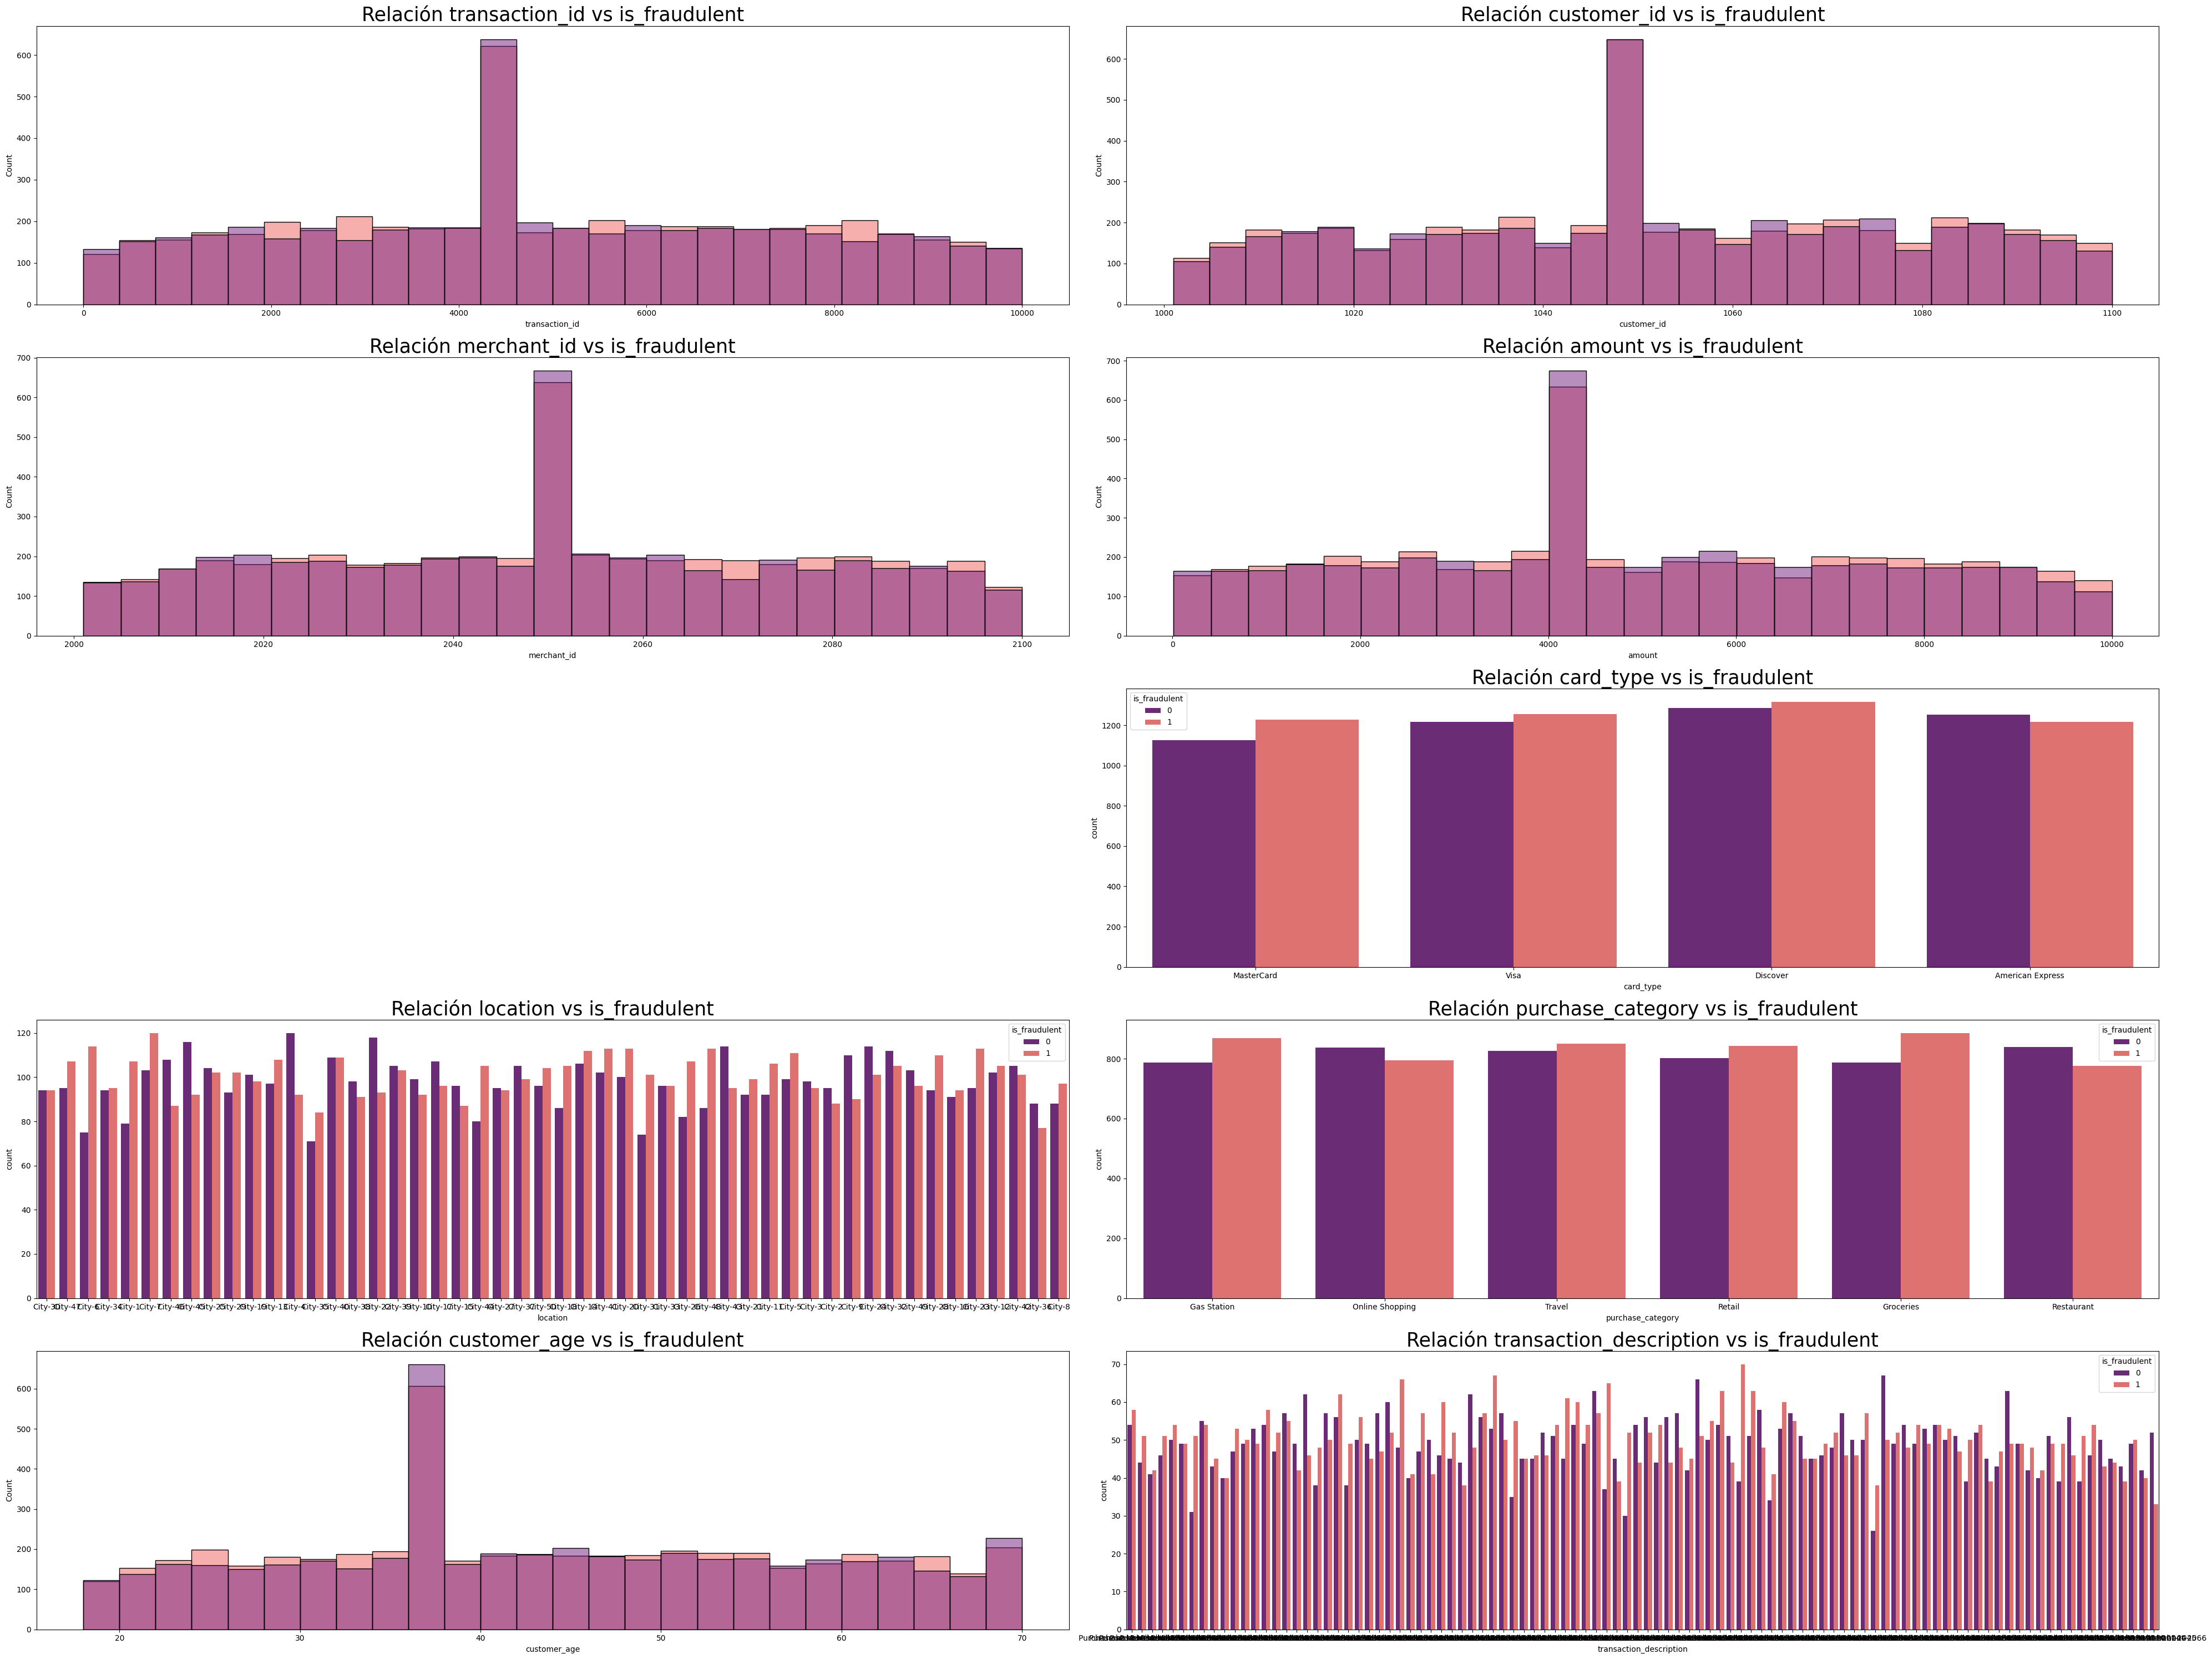

In [106]:
# Crear una instancia de la clase y llamar a los métodos
visualizador =sl.Visualizador(df)
# evaluamos la relación entre las variables independientes y dependientes
visualizador.plot_relacion(vr = "is_fraudulent",tamano_grafica=(40,30))

# Prueba de Chi cuadrado

In [108]:
# sacamos la lista de columnas categóricas
lista_col_categ = df.select_dtypes(include = ["O", "category"])

for columna in lista_col_categ:

    print(f"Analizando la relación entre IS_FRAUDULENT y {columna.upper()}")
    # Inicializar la clase
    analisis_chi2 = se.AnalisisChiCuadrado(df, variable_predictora = columna, variable_respuesta = 'is_fraudulent')

    # Generar la tabla de contingencia
    tabla_contingencia = analisis_chi2.generar_tabla_contingencia()

    # Realizar la prueba de Chi-cuadrado
    resultado_chi2 = analisis_chi2.realizar_prueba_chi_cuadrado()

    print("\n ##################################### \n")

Analizando la relación entre IS_FRAUDULENT y CARD_TYPE
Tabla de contingencia:


card_type,American Express,Discover,MasterCard,Visa
is_fraudulent,,,,
0,1254,1287,1125,1216
1,1218,1317,1228,1255



Resultado de la prueba de Chi-cuadrado:
Chi2: 4.126642446617815, p-valor: 0.24810976043816868
El p-valor >= 0.05, no hay diferencias entre los grupos.

 ##################################### 

Analizando la relación entre IS_FRAUDULENT y LOCATION
Tabla de contingencia:


location,City-1,City-10,City-11,City-12,City-13,City-14,City-15,City-16,City-17,City-18,City-19,City-2,City-20,City-21,City-22,City-23,City-24,City-25,City-26,City-27,City-28,City-29,City-3,City-30,City-31,City-32,City-33,City-34,City-35,City-36,City-37,City-38,City-39,City-4,City-40,City-41,City-42,City-43,City-44,City-45,City-46,City-47,City-48,City-49,City-5,City-50,City-6,City-7,City-8,City-9
is_fraudulent,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,79,99,92,102,97,106,96,91,107,86,101,95,100,92,118,95,114,104,82,95,94,93,98,94,74,112,96,94,71,88,105,98,105,120,109,102,105,114,80,116,108,95,86,103,99,96,75,103,88,110
1,107,92,106,105,108,112,87,94,96,105,98,88,113,99,93,113,101,102,107,94,110,102,95,94,101,105,96,95,84,77,99,91,103,92,109,113,101,95,105,92,87,107,113,96,111,104,114,120,97,90



Resultado de la prueba de Chi-cuadrado:
Chi2: 57.65760193639522, p-valor: 0.18559471344794923
El p-valor >= 0.05, no hay diferencias entre los grupos.

 ##################################### 

Analizando la relación entre IS_FRAUDULENT y PURCHASE_CATEGORY
Tabla de contingencia:


purchase_category,Gas Station,Groceries,Online Shopping,Restaurant,Retail,Travel
is_fraudulent,,,,,,
0,787,788,838,840,802,827
1,868,886,794,777,842,851



Resultado de la prueba de Chi-cuadrado:
Chi2: 12.792960131995823, p-valor: 0.025398165094166203
El p-valor < 0.05, parece que hay diferencias entre los grupos.

 ##################################### 

Analizando la relación entre IS_FRAUDULENT y TRANSACTION_DESCRIPTION
Tabla de contingencia:


transaction_description,Purchase at Merchant-2001,Purchase at Merchant-2002,Purchase at Merchant-2003,Purchase at Merchant-2004,Purchase at Merchant-2005,Purchase at Merchant-2006,Purchase at Merchant-2007,Purchase at Merchant-2008,Purchase at Merchant-2009,Purchase at Merchant-2010,Purchase at Merchant-2011,Purchase at Merchant-2012,Purchase at Merchant-2013,Purchase at Merchant-2014,Purchase at Merchant-2015,Purchase at Merchant-2016,Purchase at Merchant-2017,Purchase at Merchant-2018,Purchase at Merchant-2019,Purchase at Merchant-2020,Purchase at Merchant-2021,Purchase at Merchant-2022,Purchase at Merchant-2023,Purchase at Merchant-2024,Purchase at Merchant-2025,Purchase at Merchant-2026,Purchase at Merchant-2027,Purchase at Merchant-2028,Purchase at Merchant-2029,Purchase at Merchant-2030,Purchase at Merchant-2031,Purchase at Merchant-2032,Purchase at Merchant-2033,Purchase at Merchant-2034,Purchase at Merchant-2035,Purchase at Merchant-2036,Purchase at Merchant-2037,Purchase at Merchant-2038,Purchase at Merchant-2039,Purchase at Merchant-2040,Purchase at Merchant-2041,Purchase at Merchant-2042,Purchase at Merchant-2043,Purchase at Merchant-2044,Purchase at Merchant-2045,Purchase at Merchant-2046,Purchase at Merchant-2047,Purchase at Merchant-2048,Purchase at Merchant-2049,Purchase at Merchant-2050,Purchase at Merchant-2051,Purchase at Merchant-2052,Purchase at Merchant-2053,Purchase at Merchant-2054,Purchase at Merchant-2055,Purchase at Merchant-2056,Purchase at Merchant-2057,Purchase at Merchant-2058,Purchase at Merchant-2059,Purchase at Merchant-2060,Purchase at Merchant-2061,Purchase at Merchant-2062,Purchase at Merchant-2063,Purchase at Merchant-2064,Purchase at Merchant-2065,Purchase at Merchant-2066,Purchase at Merchant-2067,Purchase at Merchant-2068,Purchase at Merchant-2069,Purchase at Merchant-2070,Purchase at Merchant-2071,Purchase at Merchant-2072,Purchase at Merchant-2073,Purchase at Merchant-2074,Purchase at Merchant-2075,Purchase at Merchant-2076,Purchase at Merchant-2077,Purchase at Merchant-2078,Purchase at Merchant-2079,Purchase at Merchant-2080,Purchase at Merchant-2081,Purchase at Merchant-2082,Purchase at Merchant-2083,Purchase at Merchant-2084,Purchase at Merchant-2085,Purchase at Merchant-2086,Purchase at Merchant-2087,Purchase at Merchant-2088,Purchase at Merchant-2089,Purchase at Merchant-2090,Purchase at Merchant-2091,Purchase at Merchant-2092,Purchase at Merchant-2093,Purchase at Merchant-2094,Purchase at Merchant-2095,Purchase at Merchant-2096,Purchase at Merchant-2097,Purchase at Merchant-2098,Purchase at Merchant-2099,Purchase at Merchant-2100
is_fraudulent,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,43,57,45,47,38,50,45,44,35,45,62,52,67,50,49,63,52,49,66,53,49,51,47,50,54,50,54,42,49,40,40,57,31,57,41,60,46,46,57,51,56,53,44,49,42,49,45,51,63,56,51,47,44,54,56,57,54,45,54,49,53,43,62,54,49,52,37,30,39,34,40,38,56,45,45,51,43,53,42,39,50,48,50,51,48,45,39,55,46,58,50,57,46,49,54,57,50,39,56,26
1,39,46,52,52,49,41,45,38,55,44,48,46,50,55,50,57,54,45,51,49,49,49,57,53,58,56,58,45,49,42,40,55,51,47,42,52,51,54,50,45,57,49,54,50,40,52,45,63,49,44,54,53,51,48,62,50,63,39,54,42,60,47,46,44,54,33,65,52,70,41,41,48,46,61,39,44,45,67,48,49,57,52,54,47,66,46,51,54,49,48,43,55,60,54,60,48,46,50,52,38



Resultado de la prueba de Chi-cuadrado:
Chi2: 88.8690910076866, p-valor: 0.7575030277060739
El p-valor >= 0.05, no hay diferencias entre los grupos.

 ##################################### 



# Ordinales
- purchase_category
# Nominales
- card_type
- location
- transaction_description

# Ordinales

In [110]:
cols_ordinales = ["purchase_category"]

### Target Encoder

In [111]:
target_encoder = TargetEncoder(cols=cols_ordinales)
df = target_encoder.fit_transform(df,df[["is_fraudulent"]])

In [113]:
### Guardar el encoder en pickle
with open("datos/modelos-encoders/target_encoder.pkl", "wb") as f:
    pickle.dump(target_encoder,f)

# Nominales

In [115]:
cols_nominales = ["card_type","location","transaction_description"]

### One Hot Encoder

In [116]:
one_hot_encoder = OneHotEncoder(categories='auto', 
                        drop=None, 
                        sparse_output=True, 
                        dtype='float', 
                        handle_unknown='error')

# Ajustar el codificador a los datos y transformarlos
encoder_trans = one_hot_encoder.fit_transform(df[cols_nominales])

# lo siguiente que hacemos es convertir el objeto devuelto por el fit_transform a array para poder verlo
encoder_array = encoder_trans.toarray()

# usaremos el método '.get_feature_names_out()' para extraer el nombre de las columnas
nombre_columnas = one_hot_encoder.get_feature_names_out()

# creamos un DataFrame con los resultados obtenidos de la transformación
encoder_df = pd.DataFrame(encoder_array, columns = nombre_columnas)

# concatenamos estos resultados con el DataFrame original
df = pd.concat([df, encoder_df], axis = 1)

In [117]:
### Guardar el encoder en pickle
with open("datos/modelos-encoders/one_hot_encoder.pkl", "wb") as f:
    pickle.dump(one_hot_encoder,f)

# Eliminar columnas nominales
- Ya tenemos las columnas generadas y ya no nos aportan información

In [118]:
df.drop(columns=cols_nominales,inplace=True)

In [130]:
df.sample()

,transaction_id,customer_id,merchant_id,amount,is_fraudulent,purchase_category,customer_age,card_type_American Express,card_type_Discover,card_type_MasterCard,card_type_Visa,location_City-1,location_City-10,location_City-11,location_City-12,location_City-13,location_City-14,location_City-15,location_City-16,location_City-17,location_City-18,location_City-19,location_City-2,location_City-20,location_City-21,location_City-22,location_City-23,location_City-24,location_City-25,location_City-26,location_City-27,location_City-28,location_City-29,location_City-3,location_City-30,location_City-31,location_City-32,location_City-33,location_City-34,location_City-35,location_City-36,location_City-37,location_City-38,location_City-39,location_City-4,location_City-40,location_City-41,location_City-42,location_City-43,location_City-44,location_City-45,location_City-46,location_City-47,location_City-48,location_City-49,location_City-5,location_City-50,location_City-6,location_City-7,location_City-8,location_City-9,transaction_description_Purchase at Merchant-2001,transaction_description_Purchase at Merchant-2002,transaction_description_Purchase at Merchant-2003,transaction_description_Purchase at Merchant-2004,transaction_description_Purchase at Merchant-2005,transaction_description_Purchase at Merchant-2006,transaction_description_Purchase at Merchant-2007,transaction_description_Purchase at Merchant-2008,transaction_description_Purchase at Merchant-2009,transaction_description_Purchase at Merchant-2010,transaction_description_Purchase at Merchant-2011,transaction_description_Purchase at Merchant-2012,transaction_description_Purchase at Merchant-2013,transaction_description_Purchase at Merchant-2014,transaction_description_Purchase at Merchant-2015,transaction_description_Purchase at Merchant-2016,transaction_description_Purchase at Merchant-2017,transaction_description_Purchase at Merchant-2018,transaction_description_Purchase at Merchant-2019,transaction_description_Purchase at Merchant-2020,transaction_description_Purchase at Merchant-2021,transaction_description_Purchase at Merchant-2022,transaction_description_Purchase at Merchant-2023,transaction_description_Purchase at Merchant-2024,transaction_description_Purchase at Merchant-2025,transaction_description_Purchase at Merchant-2026,transaction_description_Purchase at Merchant-2027,transaction_description_Purchase at Merchant-2028,transaction_description_Purchase at Merchant-2029,transaction_description_Purchase at Merchant-2030,transaction_description_Purchase at Merchant-2031,transaction_description_Purchase at Merchant-2032,transaction_description_Purchase at Merchant-2033,transaction_description_Purchase at Merchant-2034,transaction_description_Purchase at Merchant-2035,transaction_description_Purchase at Merchant-2036,transaction_description_Purchase at Merchant-2037,transaction_description_Purchase at Merchant-2038,transaction_description_Purchase at Merchant-2039,transaction_description_Purchase at Merchant-2040,transaction_description_Purchase at Merchant-2041,transaction_description_Purchase at Merchant-2042,transaction_description_Purchase at Merchant-2043,transaction_description_Purchase at Merchant-2044,transaction_description_Purchase at Merchant-2045,transaction_description_Purchase at Merchant-2046,transaction_description_Purchase at Merchant-2047,transaction_description_Purchase at Merchant-2048,transaction_description_Purchase at Merchant-2049,transaction_description_Purchase at Merchant-2050,transaction_description_Purchase at Merchant-2051,transaction_description_Purchase at Merchant-2052,transaction_description_Purchase at Merchant-2053,transaction_description_Purchase at Merchant-2054,transaction_description_Purchase at Merchant-2055,transaction_description_Purchase at Merchant-2056,transaction_description_Purchase at Merchant-2057,transaction_description_Purchase at Merchant-2058,transaction_description_Purchase at Merchant-2059,transaction_description_Purchase at

# Featuring Scaling

# Vamos a usar MinMaxScaler
- Ya hemos gestionado los outliers

In [132]:
cols_escalar = ["transaction_id","customer_id","merchant_id","amount","purchase_category","customer_age"]
escalador_minmax = MinMaxScaler()
datos_transf_minmax = escalador_minmax.fit_transform(df[cols_escalar])
df_c = pd.DataFrame(datos_transf_minmax,columns=df[cols_escalar].columns)
df.drop(columns=cols_escalar, inplace=True)
df = pd.concat([df_c,df],axis=1)

In [134]:
with open("datos/modelos-encoders/minmax_scaler.pkl","wb") as f:
    pickle.dump(escalador_minmax, f)

In [137]:
df.to_csv("datos/03_financial_data_minmaxscaler.csv",index=False)